# **STSCI 5740 Final Project**

Tuan Anh Dang, Sam Goldberg, Matt Perez Gin, Matt Pilc

## **Load Packages**

In [57]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import math
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import tensorflow as tf

## **Load Data**

In [58]:

path = kagglehub.dataset_download("valakhorasani/bank-transaction-dataset-for-fraud-detection")

dataset_path = "/root/.cache/kagglehub/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection/versions/4/bank_transactions_data_2.csv"

# load data
bank_data = pd.read_csv(dataset_path)

#some useful info about the data
print(bank_data.head())
print(bank_data.info())

  TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor                   81 

# **Preprocessing**

In [59]:
bank_data['TransactionDate'] = pd.to_datetime(bank_data['TransactionDate'])
bank_data['PreviousTransactionDate'] = pd.to_datetime(bank_data['PreviousTransactionDate'])

# time difference between transactions
bank_data['time_between_transactions'] = (bank_data['TransactionDate'] - bank_data['PreviousTransactionDate']).dt.total_seconds()

#I am multiplying this by negative one because 'TransactionDate' is actually before 'PreviousTransactionDate' chronologically (prevent negative values)
bank_data['time_between_transactions'] = bank_data['time_between_transactions'] * -1

# remove duplicate rows
bank_data = bank_data.drop_duplicates()

# remove rows that have negative values where they do not belong
for col in ['TransactionAmount', 'TransactionDuration', 'AccountBalance']:
    bank_data = bank_data[bank_data[col] >= 0]

print(bank_data.head())

  TransactionID AccountID  TransactionAmount     TransactionDate  \
0      TX000001   AC00128              14.09 2023-04-11 16:29:14   
1      TX000002   AC00455             376.24 2023-06-27 16:44:19   
2      TX000003   AC00019             126.29 2023-07-10 18:16:08   
3      TX000004   AC00070             184.50 2023-05-05 16:32:11   
4      TX000005   AC00411              13.45 2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor                   81       

# **EDA**

### Summary Statistics

In [60]:
print("\nSummary statistics:")
print(bank_data.describe())


Summary statistics:
       TransactionAmount                TransactionDate  CustomerAge  \
count        2512.000000                           2512  2512.000000   
mean          297.593778  2023-07-05 20:32:10.826433024    44.673965   
min             0.260000            2023-01-02 16:00:06    18.000000   
25%            81.885000  2023-04-03 16:22:05.750000128    27.000000   
50%           211.140000     2023-07-07 17:49:43.500000    45.000000   
75%           414.527500     2023-10-06 18:40:53.500000    59.000000   
max          1919.110000            2024-01-01 18:21:50    80.000000   
std           291.946243                            NaN    17.792198   

       TransactionDuration  LoginAttempts  AccountBalance  \
count          2512.000000    2512.000000     2512.000000   
mean            119.643312       1.124602     5114.302966   
min              10.000000       1.000000      101.250000   
25%              63.000000       1.000000     1504.370000   
50%             112.50000

### **Univariate analysis**


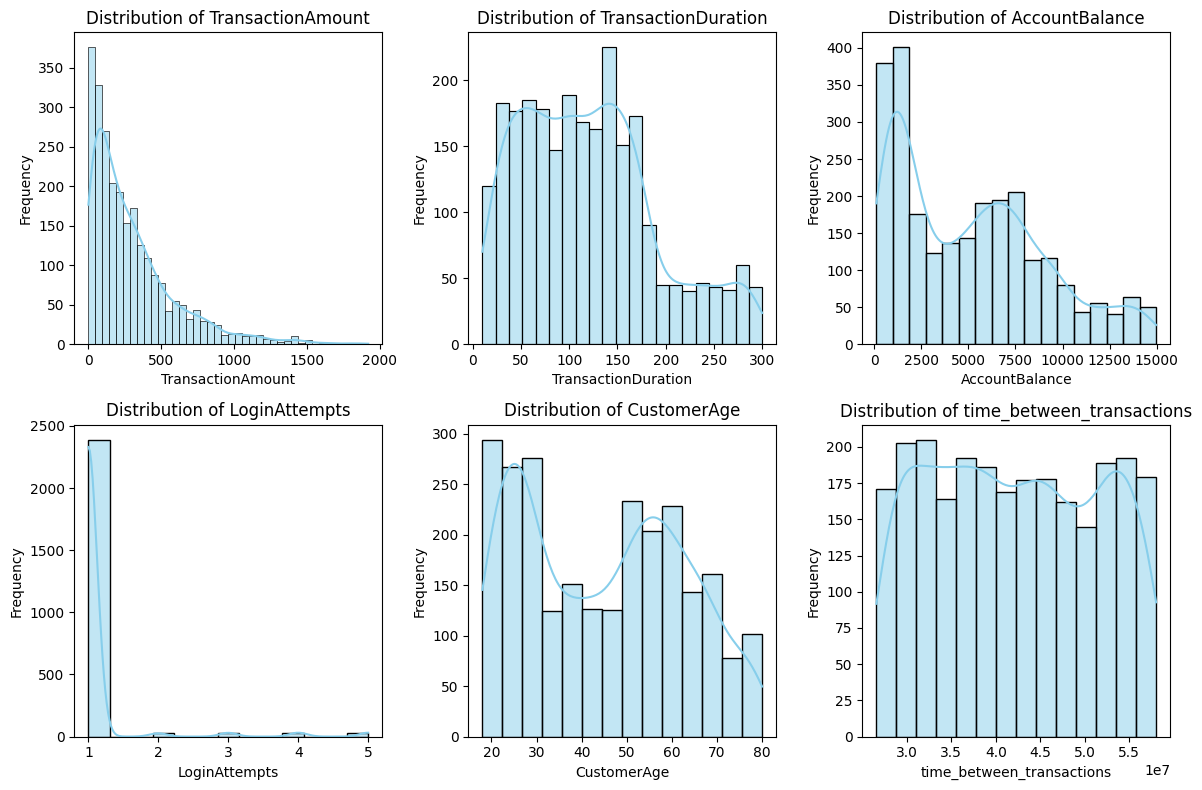

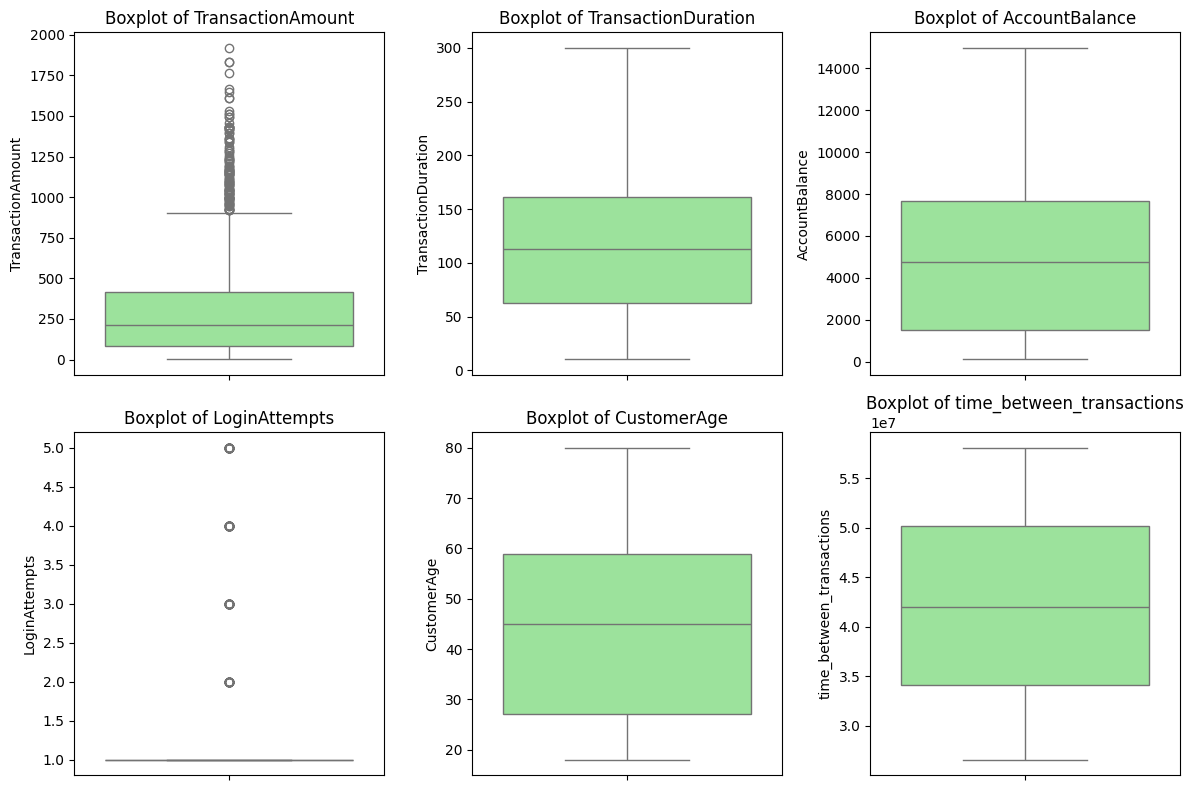

In [61]:
# histograms for numeric columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'AccountBalance',
                'LoginAttempts', 'CustomerAge', 'time_between_transactions']
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(bank_data[col], kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# boxplots to show spread and potential outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=bank_data[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


### **Bivariate Analysis**

Correlations of variables:
                           TransactionAmount  CustomerAge  \
TransactionAmount                   1.000000    -0.025616   
CustomerAge                        -0.025616     1.000000   
TransactionDuration                 0.004359    -0.017936   
LoginAttempts                      -0.008445     0.007653   
AccountBalance                     -0.025165     0.319942   
time_between_transactions          -0.024214    -0.023285   

                           TransactionDuration  LoginAttempts  AccountBalance  \
TransactionAmount                     0.004359      -0.008445       -0.025165   
CustomerAge                          -0.017936       0.007653        0.319942   
TransactionDuration                   1.000000       0.032639        0.005577   
LoginAttempts                         0.032639       1.000000        0.014999   
AccountBalance                        0.005577       0.014999        1.000000   
time_between_transactions            -0.019697       0.0207

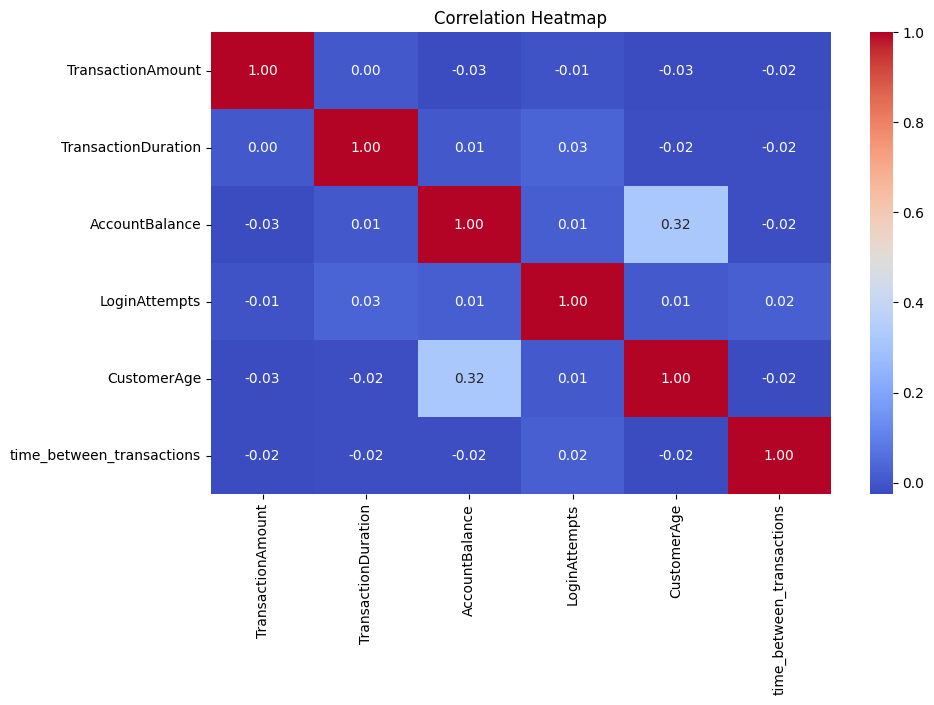

<Figure size 1200x800 with 0 Axes>

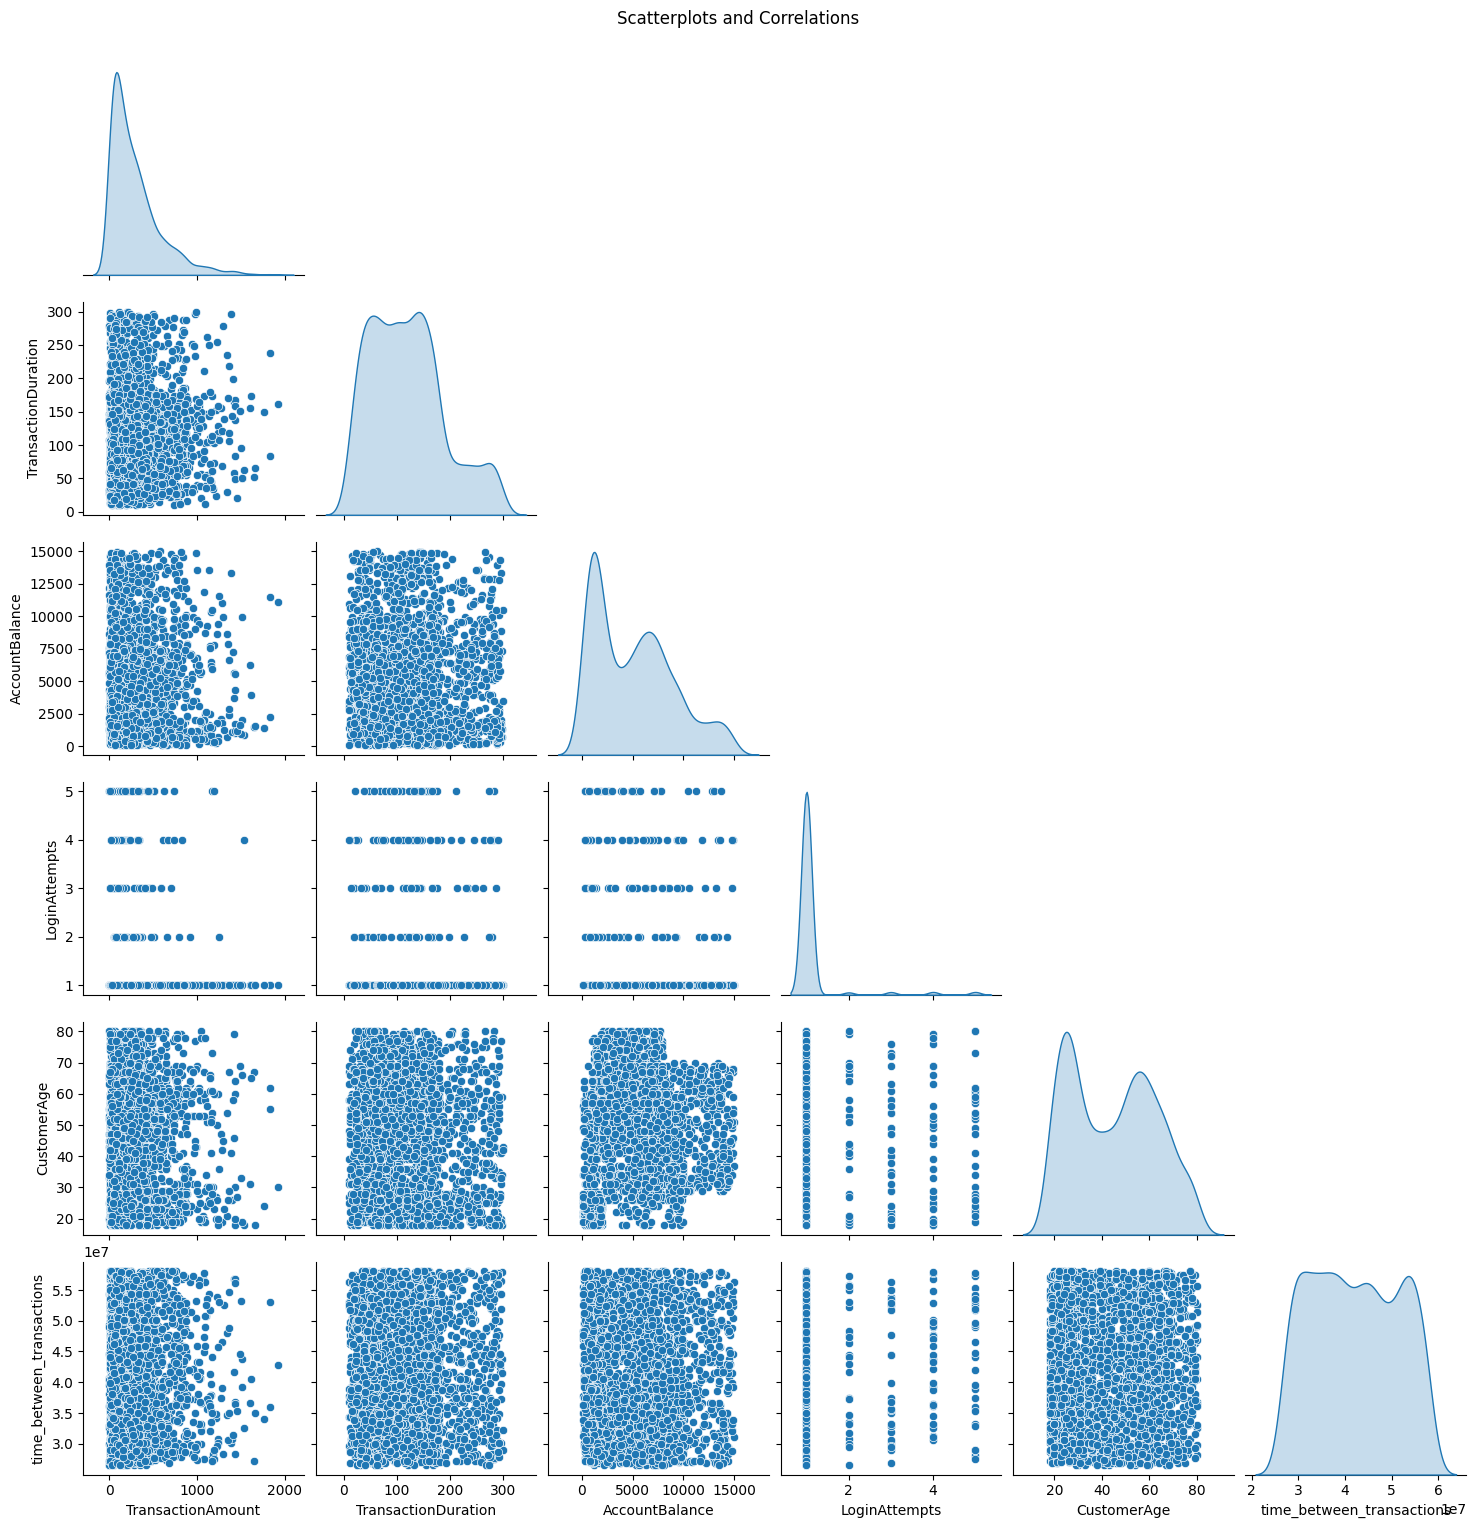

In [62]:
#correlations (not visual)

correlations = bank_data.select_dtypes(include=['float64', 'int64']).corr()
print("Correlations of variables:")
print(correlations)

# correlation heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = bank_data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# scatterplots of relationships
plt.figure(figsize=(12, 8))
sns.pairplot(bank_data[numeric_cols], diag_kind='kde', corner=True)
plt.suptitle("Scatterplots and Correlations", y=1.02)
plt.show()


### **Analysis of categorical variables**


<ipython-input-63-762e96345211>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=bank_data[col], palette='muted')
<ipython-input-63-762e96345211>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=bank_data[col], palette='muted')
<ipython-input-63-762e96345211>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=bank_data[col], palette='muted')
<ipython-input-63-762e96345211>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=Fals

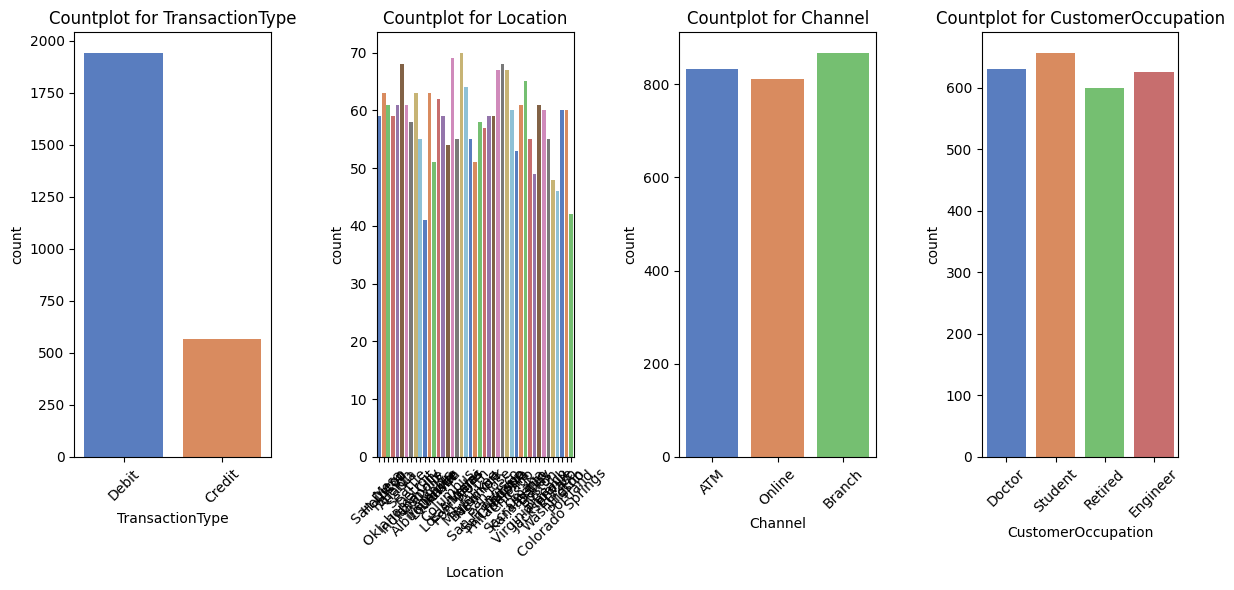

<ipython-input-63-762e96345211>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TransactionType', y='TransactionAmount', data=bank_data, palette='coolwarm')


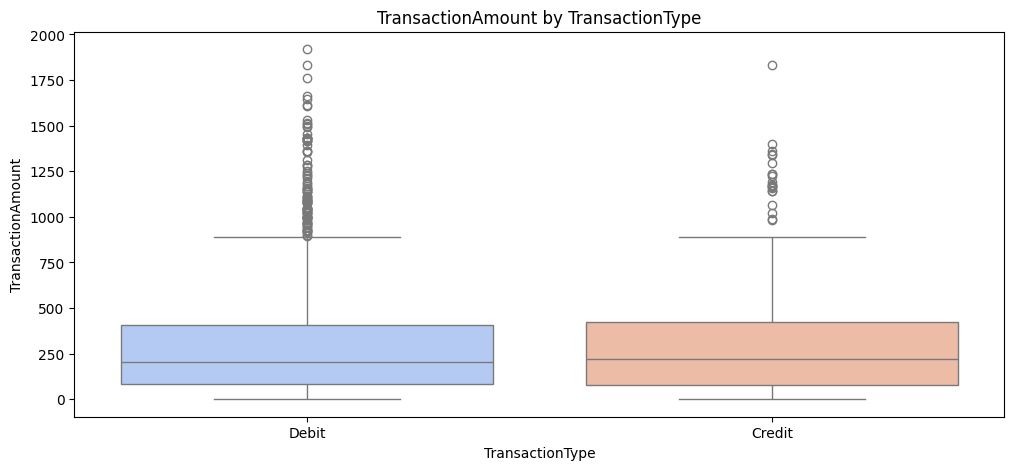

<ipython-input-63-762e96345211>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Channel', y='TransactionAmount', data=bank_data, palette='viridis')


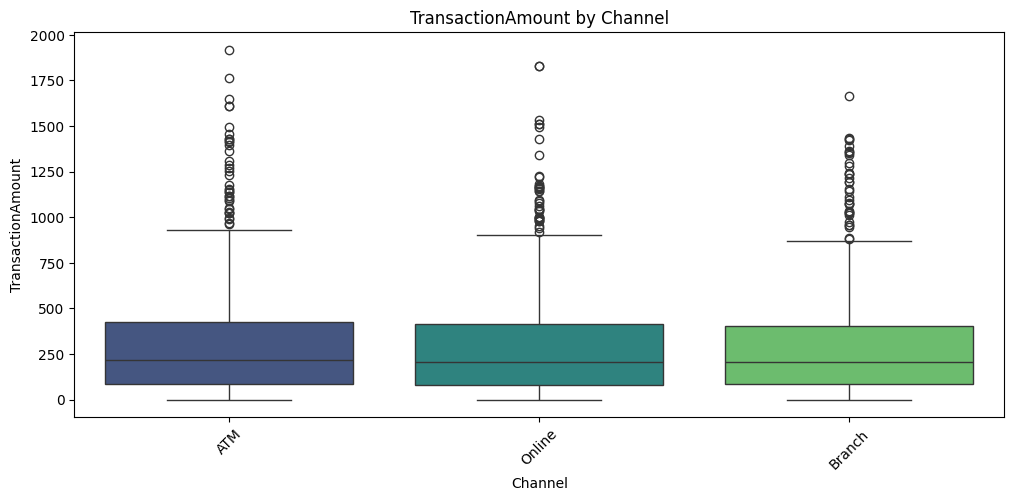

In [63]:
# frequiencies of TransactionType and Channel
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']

plt.figure(figsize=(12, 6))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 4, i + 1)
    sns.countplot(x=bank_data[col], palette='muted')
    plt.title(f"Countplot for {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# boxplots for TransactionAmount by TransactionType and Channel
plt.figure(figsize=(12, 5))
sns.boxplot(x='TransactionType', y='TransactionAmount', data=bank_data, palette='coolwarm')
plt.title("TransactionAmount by TransactionType")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x='Channel', y='TransactionAmount', data=bank_data, palette='viridis')
plt.title("TransactionAmount by Channel")
plt.xticks(rotation=45)
plt.show()


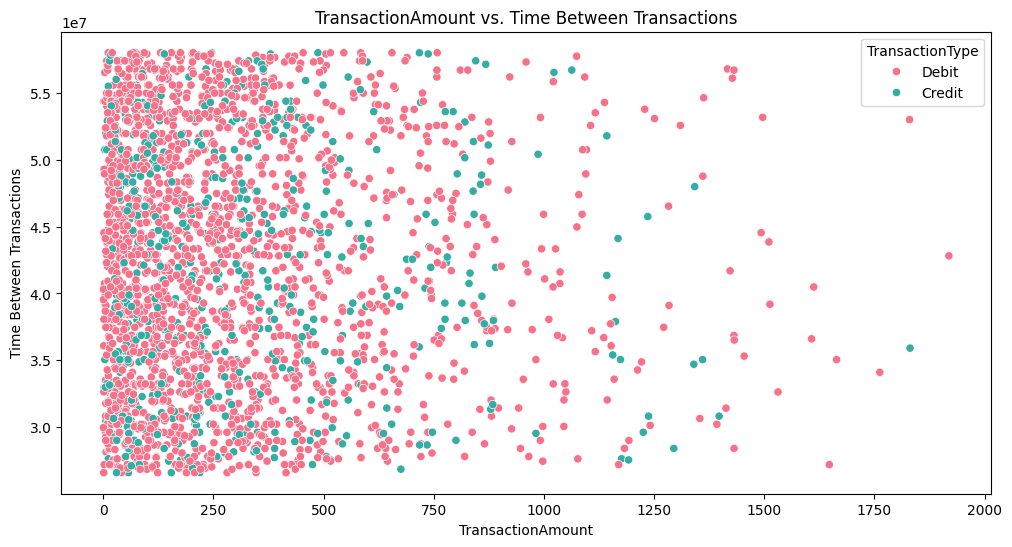

In [64]:
# outliers in TransactionAmount and time_between_transactions
#interesting to see peoeple who took out a lot of money in a very short period of time between transactions
plt.figure(figsize=(12, 6))
sns.scatterplot(data=bank_data, x='TransactionAmount', y='time_between_transactions', hue='TransactionType', palette='husl')
plt.title("TransactionAmount vs. Time Between Transactions")
plt.xlabel("TransactionAmount")
plt.ylabel("Time Between Transactions")
plt.legend(title='TransactionType')
plt.show()


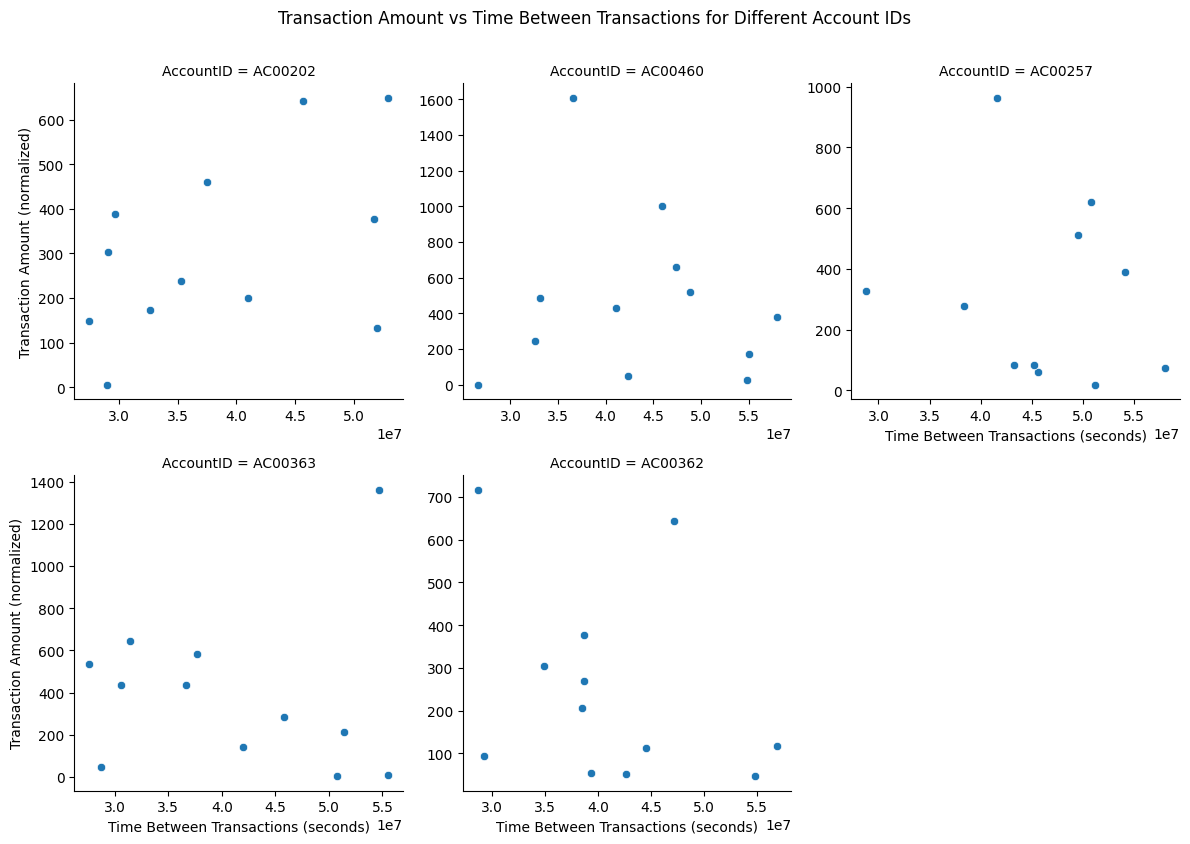

In [65]:
# subset to include only a few Account IDs for viewing purposes
top_accounts = bank_data['AccountID'].value_counts().head(5).index
filtered_data = bank_data[bank_data['AccountID'].isin(top_accounts)]

faceted_graph_person_level = sns.FacetGrid(filtered_data, col="AccountID", col_wrap=3, height=4, sharex=False, sharey=False)
faceted_graph_person_level.map_dataframe(sns.scatterplot, x='time_between_transactions', y='TransactionAmount')
faceted_graph_person_level.set_axis_labels("Time Between Transactions (seconds)", "Transaction Amount (normalized)")
faceted_graph_person_level.fig.suptitle('Transaction Amount vs Time Between Transactions for Different Account IDs', y=1.05)
plt.show()


### **Multivariate analysis**

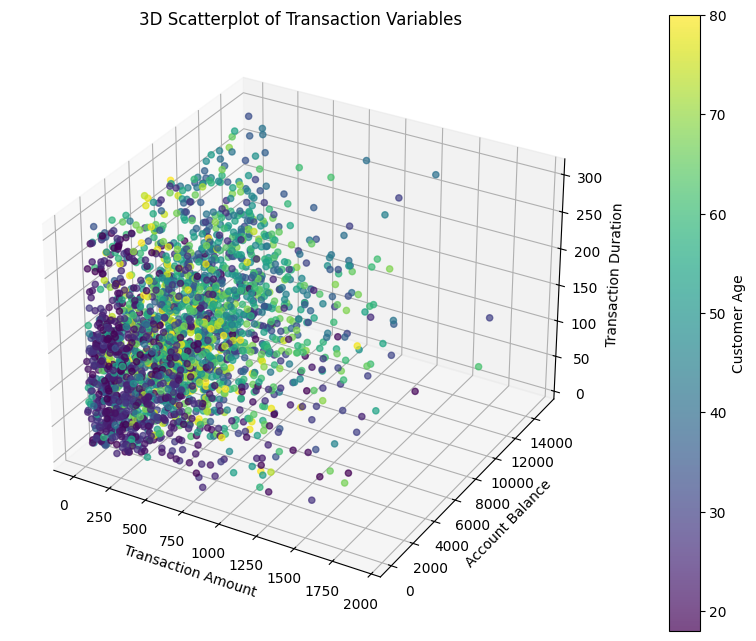

In [66]:
# 3D Scatterplot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(bank_data['TransactionAmount'],
                     bank_data['AccountBalance'],
                     bank_data['TransactionDuration'],
                     c=bank_data['CustomerAge'], cmap='viridis', alpha=0.7)

ax.set_xlabel('Transaction Amount')
ax.set_ylabel('Account Balance')
ax.set_zlabel('Transaction Duration')
plt.title('3D Scatterplot of Transaction Variables')
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Customer Age')
plt.show()


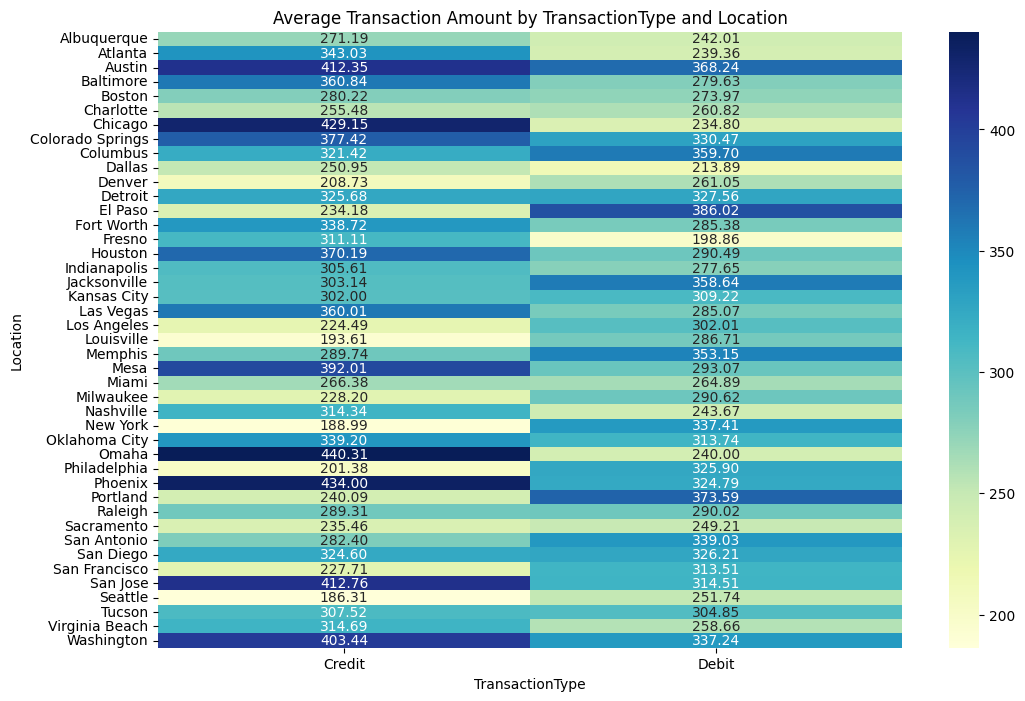

In [67]:
# piv table of avg transaction amount by transaction type and location
pivot_table = bank_data.pivot_table(values='TransactionAmount',
                                    index='Location',
                                    columns='TransactionType',
                                    aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Average Transaction Amount by TransactionType and Location')
plt.show()


## **Fraud Detection**

### **Prep Data for Use in Unsupervised Methods**

In [68]:
# normalize numeric columns, I am doing this because we will be using clustering, and other detection methods
scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(bank_data[numeric_cols])

# use one hot encoding on categorical cols
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Avoid dummy variable trap
encoded_categorical_data = encoder.fit_transform(bank_data[categorical_cols])
encoded_categorical_data = scaler.fit_transform(encoded_categorical_data)

# scaled_bank_data = np.hstack([scaled_numeric_data, encoded_categorical_data])
scaled_bank_data = scaled_numeric_data

### **K-Means Clustering**

Number of detected fraudulent transactions: 71
Anomalous transactions (top 5):
    TransactionID AccountID  TransactionAmount     TransactionDate  \
26       TX000027   AC00441             246.93 2023-04-17 16:37:01   
91       TX000092   AC00310             223.85 2023-10-02 16:36:10   
147      TX000148   AC00161             514.95 2023-04-13 18:37:48   
266      TX000267   AC00178              66.90 2023-04-17 16:50:45   
274      TX000275   AC00454            1176.28 2023-12-20 16:08:02   

    TransactionType     Location DeviceID       IP Address MerchantID Channel  \
26            Debit        Miami  D000046   55.154.161.250       M029     ATM   
91            Debit  Kansas City  D000481  133.223.159.151       M009     ATM   
147           Debit     New York  D000109     23.92.205.75       M056  Online   
266          Credit    Charlotte  D000221   138.210.196.19       M021  Online   
274          Credit  Kansas City  D000476      50.202.8.53       M074     ATM   

     Customer

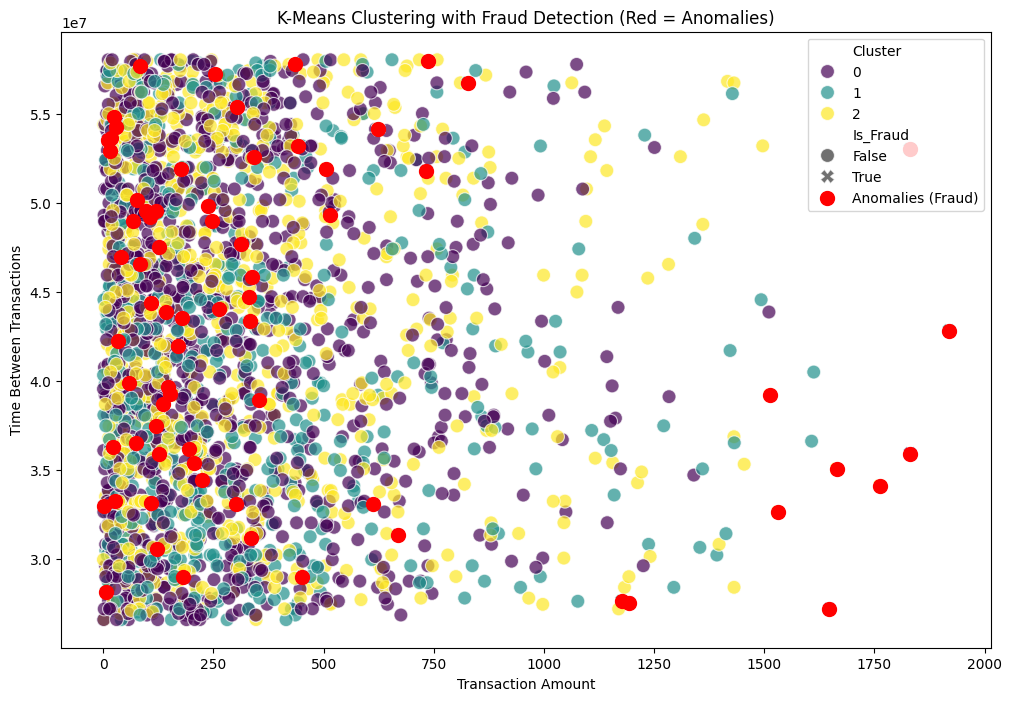

In [69]:
# set number of clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
cluster_data = pd.DataFrame(scaled_bank_data)
cluster_data['Cluster'] = kmeans.fit_predict(scaled_bank_data)

# distance to cluster centroids
distances = np.linalg.norm(scaled_bank_data - kmeans.cluster_centers_[cluster_data['Cluster']], axis=1)
cluster_data['Distance_to_Centroid'] = distances

# anomoly flagging logic - we are using mean + 3 * std as a threshold for identifying anomalies
threshold = distances.mean() + 3 * distances.std()
cluster_data['Is_Fraud'] = cluster_data['Distance_to_Centroid'] > threshold

# augment original bank_data with results
bank_data['Cluster'] = cluster_data['Cluster']
bank_data['Distance_to_Centroid'] = cluster_data['Distance_to_Centroid']
bank_data['Is_Fraud'] = cluster_data['Is_Fraud']

# results
print("Number of detected fraudulent transactions:", bank_data['Is_Fraud'].sum())
print("Anomalous transactions (top 5):")
print(bank_data[bank_data['Is_Fraud'] == True].head())

# clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=bank_data['TransactionAmount'],
    y=bank_data['time_between_transactions'],
    hue=bank_data['Cluster'],
    palette='viridis',
    style=bank_data['Is_Fraud'],
    markers={True: "X", False: "o"},
    s=100,
    alpha=0.7
)

# fraud points
fraud_points = bank_data[bank_data['Is_Fraud']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['time_between_transactions'],
    color='red',
    label='Anomalies (Fraud)',
    s=100
)

# labels
plt.title("K-Means Clustering with Fraud Detection (Red = Anomalies)")
plt.xlabel("Transaction Amount")
plt.ylabel("Time Between Transactions")
plt.legend()
plt.show()

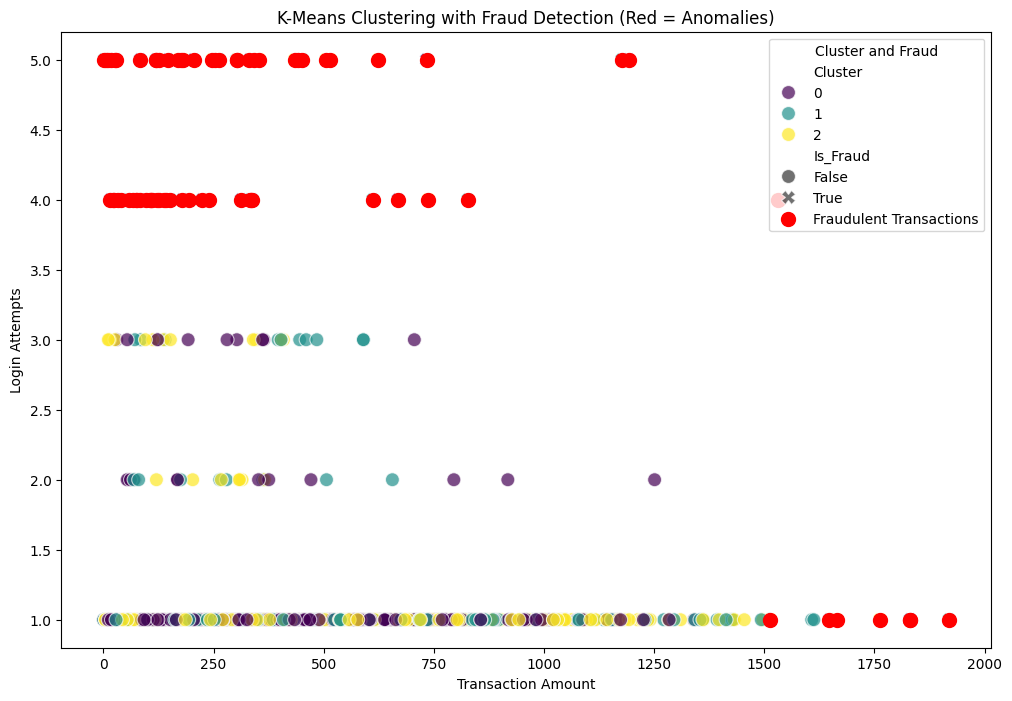

In [70]:
plt.figure(figsize=(12, 8))

# Plot all transactions
sns.scatterplot(
    x=bank_data['TransactionAmount'],
    y=bank_data['LoginAttempts'],
    hue=bank_data['Cluster'],  # Clusters shown using colors
    palette='viridis',
    style=bank_data['Is_Fraud'],  # Fraud style highlighted
    markers={True: "X", False: "o"},
    s=100,
    alpha=0.7
)

# Highlight fraudulent transactions
fraud_points = bank_data[bank_data['Is_Fraud']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['LoginAttempts'],
    color='red',
    label='Fraudulent Transactions',
    s=100
)

# Labels and title
plt.title("K-Means Clustering with Fraud Detection (Red = Anomalies)")
plt.xlabel("Transaction Amount")
plt.ylabel("Login Attempts")
plt.legend(title="Cluster and Fraud", loc="upper right")
plt.show()


### **PCA for Dimension Reduction Before K-Means Clustering**

- Our results for our initial k-means clustering on the data used the scaled bank fraud data that normalized the numeric columns. Our first iteration of k-means clustering process resulted in a very dense visualization; however, we believe performing PCA will reduce our dimensionality of the dataset which retaining as much information as possible. To start will will try to identify a and reduce the data to two principal components, allowing for better visualization in two dimensions

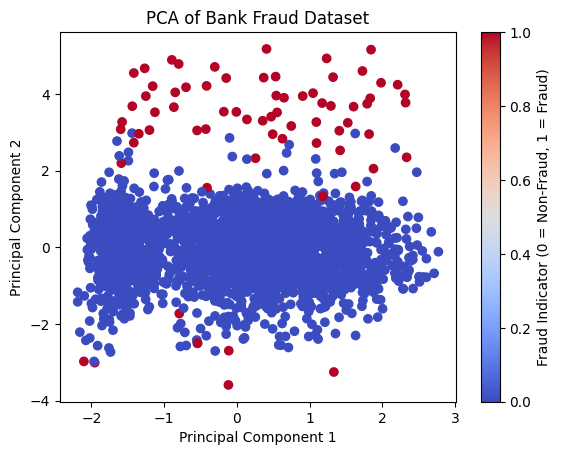

In [71]:
# target variabl = "Is_Fraud"
target = bank_data['Is_Fraud']

# Apply PCA on our SCALED bank data because PCA
# is sensitive to different scales of features and we want
# numeric representations of the data
pca = PCA(n_components=4)
X_pca = pca.fit_transform(scaled_bank_data)

# Plot the transformed data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=target, cmap='coolwarm')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Bank Fraud Dataset')
plt.colorbar(label='Fraud Indicator (0 = Non-Fraud, 1 = Fraud)')
plt.show()

In [72]:
# Variance explained by each principal component
print(pca.explained_variance_ratio_)

[0.22117157 0.17273477 0.1719889  0.16309399]


[0.22117157 0.39390635 0.56589524 0.72898923]


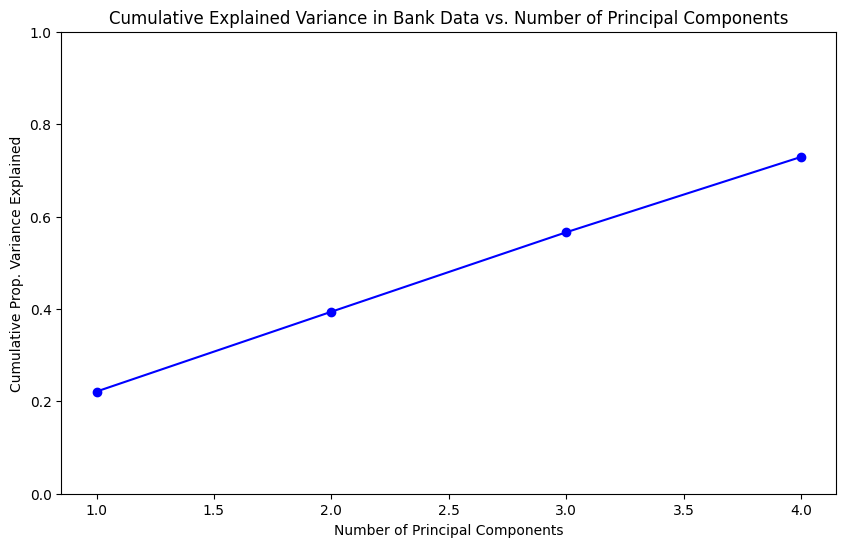

In [73]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
print(cumulative_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Prop. Variance Explained')
plt.title('Cumulative Explained Variance in Bank Data vs. Number of Principal Components')
plt.ylim(0,1)
plt.show()

- Above, we see that 5 principal components account for just about 70% of the variance in our data, which is a good basis to use

In [74]:
# feature_names = list(bank_data[numeric_cols].columns) + list(encoder.get_feature_names_out(categorical_cols))
feature_names = list(bank_data[numeric_cols].columns)
loadings = pd.DataFrame(pca.components_, columns=feature_names, index=['PC1', 'PC2', 'PC3', 'PC4'])

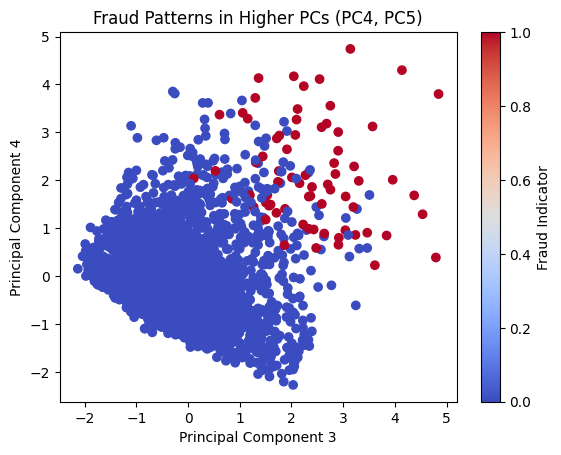

In [75]:
plt.scatter(X_pca[:, 2], X_pca[:, 3], c=target, cmap='coolwarm')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.title('Fraud Patterns in Higher PCs (PC4, PC5)')
plt.colorbar(label='Fraud Indicator')
plt.show()

In [76]:
print(loadings.loc[['PC1', 'PC2', 'PC3', 'PC4']])

     TransactionAmount  TransactionDuration  AccountBalance  LoginAttempts  \
PC1          -0.104213            -0.018657        0.699807       0.044263   
PC2          -0.493507             0.170347       -0.004328       0.602023   
PC3           0.298591             0.750414        0.023379       0.431527   
PC4           0.786555            -0.316885        0.059506       0.359521   

     CustomerAge  time_between_transactions  
PC1     0.700536                  -0.079696  
PC2    -0.033971                   0.603182  
PC3    -0.031715                  -0.399944  
PC4     0.069475                   0.378540  


In [77]:
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

cumulative_variance = explained_variance_ratio.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)

[0.22117157 0.17273477 0.1719889  0.16309399]
Cumulative Explained Variance: [0.22117157 0.39390635 0.56589524 0.72898923]


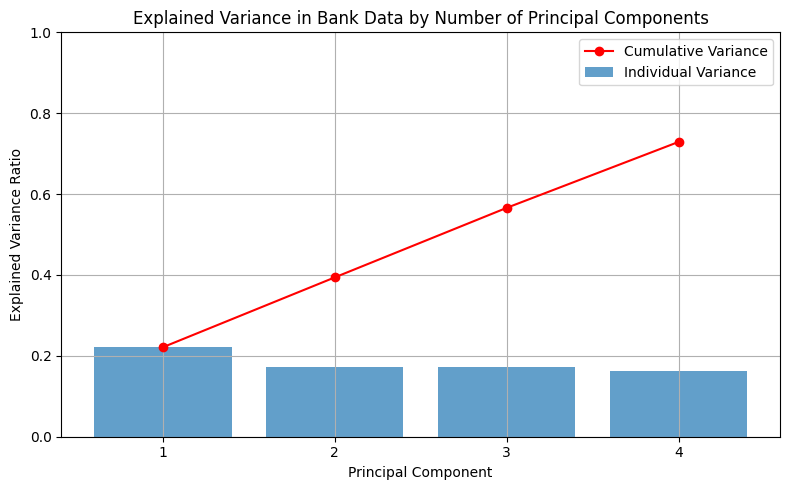

In [78]:
cumulative_variance = np.cumsum(explained_variance_ratio)

# explained variance plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r', label='Cumulative Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.xlabel('Principal Component')
plt.ylim(0,1)
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance in Bank Data by Number of Principal Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Above, we see that PCA with 4 principal components accounts for 72.898923 of the variance in our data, which is better than the 22.117157% percent that just the first to Principal Components account for. With this dimensionality reduction, we can observe the following contributions to the principal components:

- TransactionAmount contributes significantly to PC2 and PC4.
TransactionDuration contributes primarily to PC3 and PC4. AccountBalance has the highest contribution to PC1. LoginAttempts contributes to PC2, PC3, and PC4. CustomerAge predominantly contributes to PC1. time_between_transactions contributes most to PC2.

Given that a substantial proportion of the variance is explained by the first 4 principal components, we proceed to use this dimensionally reduced data for our K-means clustering to evaluate whether it improves clustering performance and anomaly detection.

Because we found that most of the variance in the data contributes to the first 4 principal componenets, we can now pass this data through to see if our k-means clustering performs better now with PCA dimension reduction

In [79]:
# save pca dimension reduced data to variable

PCA_reduced_bank_data = X_pca[:, :4]

### **K-Means Clustering with PCA Dimension-Reduced Data**

Number of detected fraudulent transactions: 17
Anomalous transactions (top 5):
    TransactionID AccountID  TransactionAmount     TransactionDate  \
274      TX000275   AC00454            1176.28 2023-12-20 16:08:02   
340      TX000341   AC00107            1830.00 2023-03-01 16:31:58   
341      TX000342   AC00171              26.06 2023-12-21 17:01:24   
375      TX000376   AC00316            1392.54 2023-11-20 16:51:14   
394      TX000395   AC00326               6.30 2023-12-14 18:52:54   

    TransactionType     Location DeviceID       IP Address MerchantID Channel  \
274          Credit  Kansas City  D000476      50.202.8.53       M074     ATM   
340           Debit  San Antonio  D000436    62.27.235.199       M082  Online   
341           Debit    San Diego  D000689  140.212.253.222       M096     ATM   
375           Debit      El Paso  D000113    63.67.150.226       M013  Branch   
394           Debit     Columbus  D000539    210.160.90.52       M017  Branch   

     ...  Cus

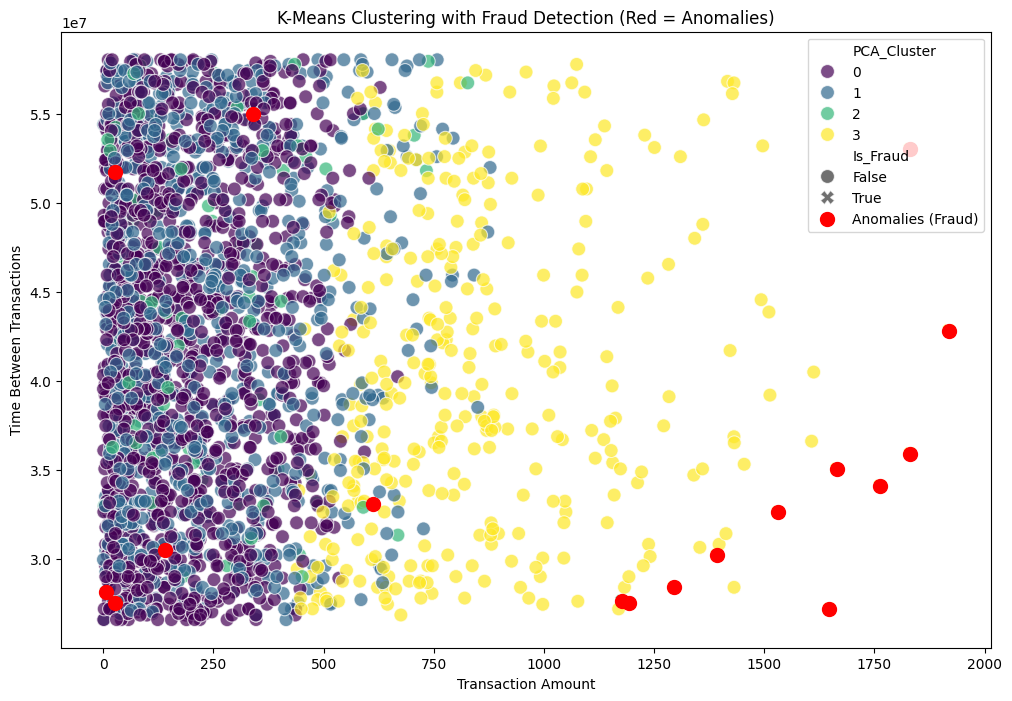

In [80]:
# set number of clusters
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
bank_data['PCA_Cluster'] = kmeans.fit_predict(PCA_reduced_bank_data)

# distance to cluster centroids
distances = np.linalg.norm(PCA_reduced_bank_data - kmeans.cluster_centers_[kmeans.labels_], axis=1)
bank_data['Distance_to_Centroid'] = distances

# anomoly flagging logic - we are using mean + 3 * std as a threshold for identifying anomalies
threshold = distances.mean() + 3 * distances.std()
bank_data['Is_Fraud'] = bank_data['Distance_to_Centroid'] > threshold

# results
print("Number of detected fraudulent transactions:", bank_data['Is_Fraud'].sum())
print("Anomalous transactions (top 5):")
print(bank_data[bank_data['Is_Fraud'] == True].head())

# clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=bank_data['TransactionAmount'],
    y=bank_data['time_between_transactions'],
    hue=bank_data['PCA_Cluster'],
    palette='viridis',
    style=bank_data['Is_Fraud'],
    markers={True: "X", False: "o"},
    s=100,
    alpha=0.7
)

# fraud points
fraud_points = bank_data[bank_data['Is_Fraud']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['time_between_transactions'],
    color='red',
    label='Anomalies (Fraud)',
    s=100
)

# labels
plt.title("K-Means Clustering with Fraud Detection (Red = Anomalies)")
plt.xlabel("Transaction Amount")
plt.ylabel("Time Between Transactions")
plt.legend()
plt.show()


Number of detected fraudulent transactions: 17
Anomalous transactions (top 5):
    TransactionID AccountID  TransactionAmount     TransactionDate  \
274      TX000275   AC00454            1176.28 2023-12-20 16:08:02   
340      TX000341   AC00107            1830.00 2023-03-01 16:31:58   
341      TX000342   AC00171              26.06 2023-12-21 17:01:24   
375      TX000376   AC00316            1392.54 2023-11-20 16:51:14   
394      TX000395   AC00326               6.30 2023-12-14 18:52:54   

    TransactionType     Location DeviceID       IP Address MerchantID Channel  \
274          Credit  Kansas City  D000476      50.202.8.53       M074     ATM   
340           Debit  San Antonio  D000436    62.27.235.199       M082  Online   
341           Debit    San Diego  D000689  140.212.253.222       M096     ATM   
375           Debit      El Paso  D000113    63.67.150.226       M013  Branch   
394           Debit     Columbus  D000539    210.160.90.52       M017  Branch   

     ...  Cus

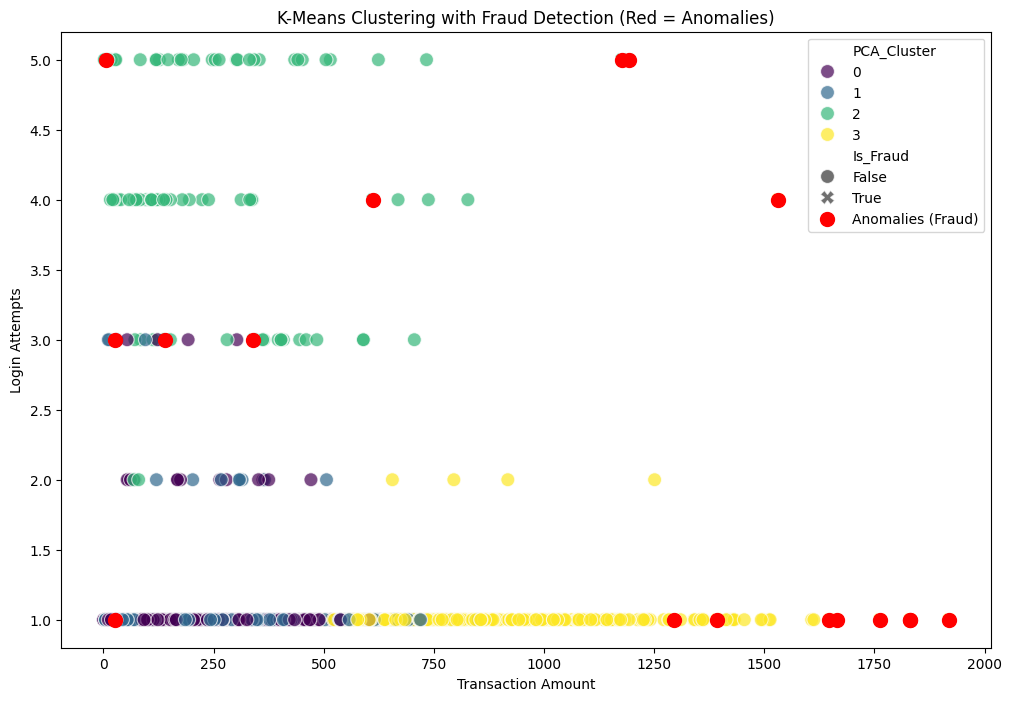

In [81]:
# set number of clusters
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
bank_data['PCA_Cluster'] = kmeans.fit_predict(PCA_reduced_bank_data)

# distance to cluster centroids
distances = np.linalg.norm(PCA_reduced_bank_data - kmeans.cluster_centers_[kmeans.labels_], axis=1)
bank_data['Distance_to_Centroid'] = distances

# anomoly flagging logic - we are using mean + 3 * std as a threshold for identifying anomalies
threshold = distances.mean() + 3 * distances.std()
bank_data['Is_Fraud'] = bank_data['Distance_to_Centroid'] > threshold

# results
print("Number of detected fraudulent transactions:", bank_data['Is_Fraud'].sum())
print("Anomalous transactions (top 5):")
print(bank_data[bank_data['Is_Fraud'] == True].head())

# clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=bank_data['TransactionAmount'],
    y=bank_data['LoginAttempts'],
    hue=bank_data['PCA_Cluster'],
    palette='viridis',
    style=bank_data['Is_Fraud'],
    markers={True: "X", False: "o"},
    s=100,
    alpha=0.7
)

# fraud points
fraud_points = bank_data[bank_data['Is_Fraud']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['LoginAttempts'],
    color='red',
    label='Anomalies (Fraud)',
    s=100
)

# labels
plt.title("K-Means Clustering with Fraud Detection (Red = Anomalies)")
plt.xlabel("Transaction Amount")
plt.ylabel("Login Attempts")
plt.legend()
plt.show()

In [82]:
print(bank_data[bank_data['LoginAttempts'].between(4, 5)])
print(bank_data['PCA_Cluster'].value_counts())


     TransactionID AccountID  TransactionAmount     TransactionDate  \
26        TX000027   AC00441             246.93 2023-04-17 16:37:01   
91        TX000092   AC00310             223.85 2023-10-02 16:36:10   
147       TX000148   AC00161             514.95 2023-04-13 18:37:48   
266       TX000267   AC00178              66.90 2023-04-17 16:50:45   
274       TX000275   AC00454            1176.28 2023-12-20 16:08:02   
...            ...       ...                ...                 ...   
2262      TX002263   AC00279              15.81 2023-03-02 18:36:55   
2288      TX002289   AC00149             336.01 2023-11-09 18:45:10   
2310      TX002311   AC00243             176.52 2023-03-14 17:06:18   
2371      TX002372   AC00465              21.23 2023-09-11 16:35:15   
2423      TX002424   AC00340             332.06 2023-06-21 16:38:54   

     TransactionType          Location DeviceID       IP Address MerchantID  \
26             Debit             Miami  D000046   55.154.161.250    

- Above, we changes the y_axis from Time Between Transactions to Login Attempts. Typically, we would assume that the number of login attempts for fraud is high because fraudsters are attempting to try to get into a given account and may not know the personal login information; however, we see that the vast majority of Anomolies identified by our k-means clustering unsupervised method occured with only 1 login attempt, with a few relatively high transaction amounts requiring 2 to 5 login attempts and one outlier of a low transaction amount anomoly taking 5 login attempts. With this insight, we can suggest that a high number of login attempts (like someone continously trying to guess passwords) by potential fraudsters may not directly correlate to fradulent activity.
- This could be important information for security teams as lots of fraudulent activity may go undetected if we assume that more login attempts result in more fraud.
- This is something I was still somewhat concerned by, so we want to flag this and dig deeper because this may not be the most robust example of fraudulent activity based on login attempts

# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
Initially like with KNN, we apporach the problem with the DBSCAN grouping the raw data points into dense regions (clusters) while flagging sparse points as noise (Cluster = -1), which we labeled as potential anomalies or fraud.

DBSCAN Silhouette Score: 0.19893039766083523
Number of detected fraudulent transactions (DBSCAN): 197
Anomalous transactions (top 5 - DBSCAN):
   TransactionID AccountID  TransactionAmount     TransactionDate  \
23      TX000024   AC00453             345.84 2023-05-02 18:25:46   
26      TX000027   AC00441             246.93 2023-04-17 16:37:01   
32      TX000033   AC00060             396.45 2023-09-25 16:26:00   
38      TX000039   AC00478             795.31 2023-10-12 17:07:40   
61      TX000062   AC00002             263.99 2023-05-16 16:07:30   

   TransactionType    Location DeviceID      IP Address MerchantID Channel  \
23           Debit  Fort Worth  D000162  191.82.103.198       M083  Online   
26           Debit       Miami  D000046  55.154.161.250       M029     ATM   
32           Debit    New York  D000621  133.67.250.163       M007     ATM   
38           Debit        Mesa  D000077    49.29.37.185       M048     ATM   
61           Debit      Dallas  D000285    7.146.35.

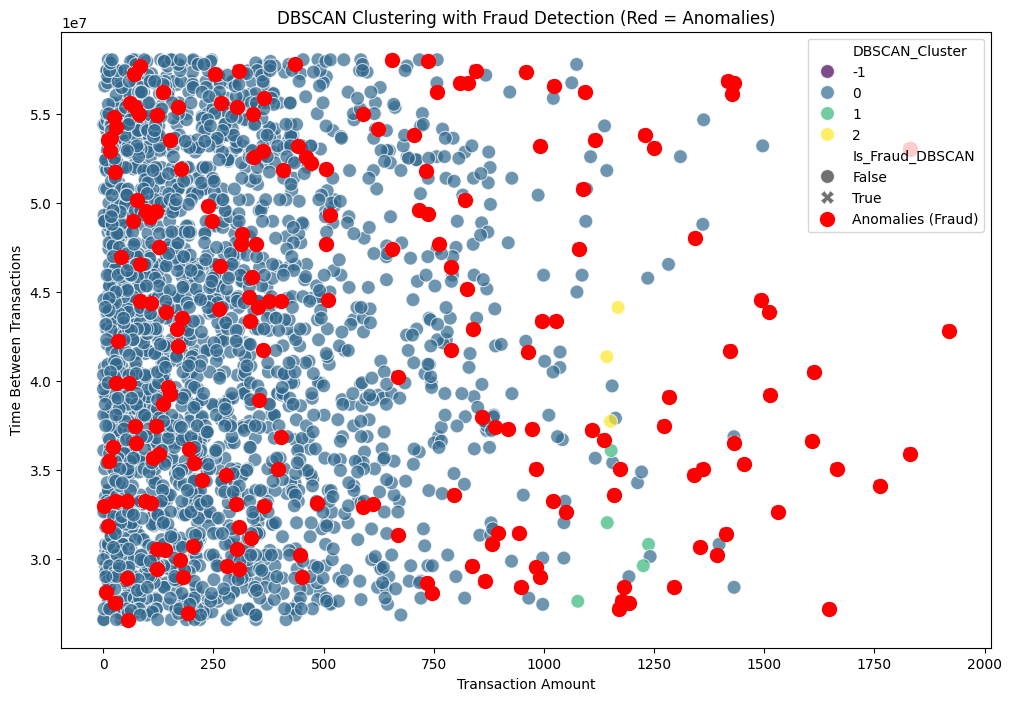

In [83]:
dbscan = DBSCAN(eps=1, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_bank_data)

# Add cluster labels to the dataset
bank_data['DBSCAN_Cluster'] = dbscan_labels

# Evaluate the clusters (silhouette score excludes noise points, labeled -1)
if len(set(dbscan_labels)) > 1:  # Silhouette score needs at least 2 clusters
    dbscan_silhouette = silhouette_score(scaled_bank_data, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
else:
    print("DBSCAN resulted in a single cluster. Try adjusting hyperparameters.")

# Identify anomalies (noise points labeled as -1 by DBSCAN)
bank_data['Is_Fraud_DBSCAN'] = bank_data['DBSCAN_Cluster'] == -1

# Results
print("Number of detected fraudulent transactions (DBSCAN):", bank_data['Is_Fraud_DBSCAN'].sum())
print("Anomalous transactions (top 5 - DBSCAN):")
print(bank_data[bank_data['Is_Fraud_DBSCAN']].head())

# Visualize
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=bank_data['TransactionAmount'],
    y=bank_data['time_between_transactions'],
    hue=bank_data['DBSCAN_Cluster'],
    palette='viridis',
    style=bank_data['Is_Fraud_DBSCAN'],
    markers={True: "X", False: "o"},
    s=100,
    alpha=0.7
)

# fraud points
fraud_points = bank_data[bank_data['Is_Fraud_DBSCAN']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['time_between_transactions'],
    color='red',
    label='Anomalies (Fraud)',
    s=100
)

plt.title("DBSCAN Clustering with Fraud Detection (Red = Anomalies)")
plt.xlabel("Transaction Amount")
plt.ylabel("Time Between Transactions")
plt.legend()
plt.show()

- After performing DBSCAN on the scaled_bank_data (no PCA), we see that the majority of detected anomalies are within the densly populated space on the left side of the clustering plot. We think that using our PCA dimension-reduced data may help us see clustering that it more distinct.
- Additionally, we notice that when compared to KNN, our dbscan algorithm categorizes a lot more transactions as fraud, this is something which we will address in the next revision also.

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise) with PCA dimension reduced data and Elbow Method

In [84]:
PCA_reduced_bank_data_dbscan = X_pca[:,:5]

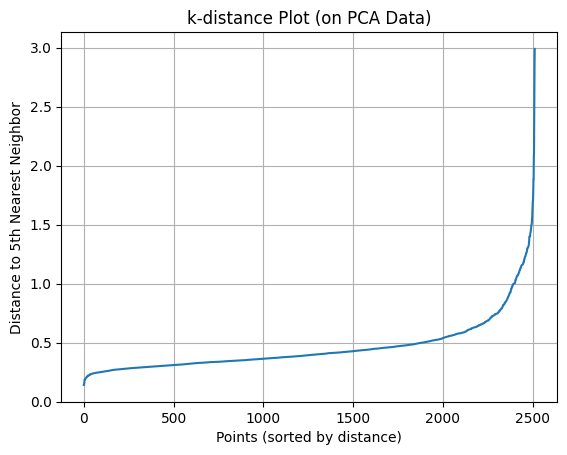

In [85]:
# using n_neighbors=5 as a baseline
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(PCA_reduced_bank_data_dbscan)
distances, _ = neighbors_fit.kneighbors(PCA_reduced_bank_data_dbscan)

# Sort distances for the k-distance plot
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.title("k-distance Plot (on PCA Data)")
plt.xlabel("Points (sorted by distance)")
plt.ylabel("Distance to 5th Nearest Neighbor")
plt.grid(True)
plt.show()

- We wanted to see what the optimal eps, or neighborhood size would be using the PCA reduced data, so I used sklearn NearestNeighbors to find the optimal value. We can refer to the "elbow" in the k-distance plot and find the optimal distance to which we found that eps = 1.1 is appoximately the distance which the points stop being "neighbors"

DBSCAN Silhouette Score: 0.37690717853069283
Number of detected fraudulent transactions (DBSCAN): 38
Anomalous transactions (top 5 - DBSCAN):
    TransactionID AccountID  TransactionAmount     TransactionDate  \
26       TX000027   AC00441             246.93 2023-04-17 16:37:01   
231      TX000232   AC00430             705.60 2023-02-20 18:41:43   
274      TX000275   AC00454            1176.28 2023-12-20 16:08:02   
340      TX000341   AC00107            1830.00 2023-03-01 16:31:58   
375      TX000376   AC00316            1392.54 2023-11-20 16:51:14   

    TransactionType     Location DeviceID      IP Address MerchantID Channel  \
26            Debit        Miami  D000046  55.154.161.250       M029     ATM   
231           Debit      Phoenix  D000103   205.45.234.42       M071  Branch   
274          Credit  Kansas City  D000476     50.202.8.53       M074     ATM   
340           Debit  San Antonio  D000436   62.27.235.199       M082  Online   
375           Debit      El Paso  D00

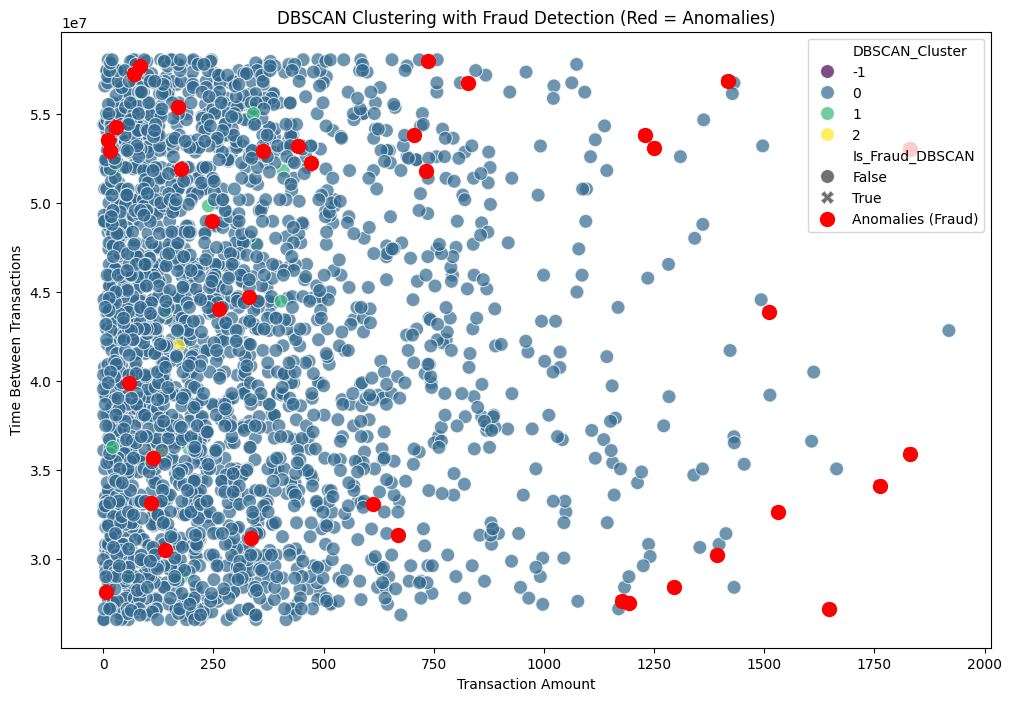

In [86]:
# Apply DBSCAN
dbscan = DBSCAN(eps=1.1, min_samples=5)
dbscan_labels = dbscan.fit_predict(PCA_reduced_bank_data_dbscan)

# Add cluster labels to the dataset
bank_data['DBSCAN_Cluster'] = dbscan_labels

# Evaluate the clusters (silhouette score excludes noise points, labeled -1)
if len(set(dbscan_labels)) > 1:  # Silhouette score needs at least 2 clusters
    dbscan_silhouette = silhouette_score(PCA_reduced_bank_data_dbscan, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
else:
    print("DBSCAN resulted in a single cluster. Try adjusting hyperparameters.")

# Identify anomalies (noise points labeled as -1 by DBSCAN)
bank_data['Is_Fraud_DBSCAN'] = bank_data['DBSCAN_Cluster'] == -1

# Results
print("Number of detected fraudulent transactions (DBSCAN):", bank_data['Is_Fraud_DBSCAN'].sum())
print("Anomalous transactions (top 5 - DBSCAN):")
print(bank_data[bank_data['Is_Fraud_DBSCAN']].head())

# Visualize
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=bank_data['TransactionAmount'],
    y=bank_data['time_between_transactions'],
    hue=bank_data['DBSCAN_Cluster'],
    palette='viridis',
    style=bank_data['Is_Fraud_DBSCAN'],
    markers={True: "X", False: "o"},
    s=100,
    alpha=0.7
)

# fraud points
fraud_points = bank_data[bank_data['Is_Fraud_DBSCAN']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['time_between_transactions'],
    color='red',
    label='Anomalies (Fraud)',
    s=100
)

plt.title("DBSCAN Clustering with Fraud Detection (Red = Anomalies)")
plt.xlabel("Transaction Amount")
plt.ylabel("Time Between Transactions")
plt.legend()
plt.show()

- Above, we see our DBSCAN visualization and results using the PCA dimenion reduced bank data. While we notice that the anomolies (fraud points) are spread out relatively consistently throughout the entire plot, what is insightful is that towards the higher transaction amounts, there is a separation of anomalies ranging from Transaction Amounts of around 1000 to 2000. This aligns with our previous k-means clustering vidual with the dimension-reduced PCA data.
- We notice that the clusters that DBSCAN made show that the data still possesses an observably dense region where the data lies.

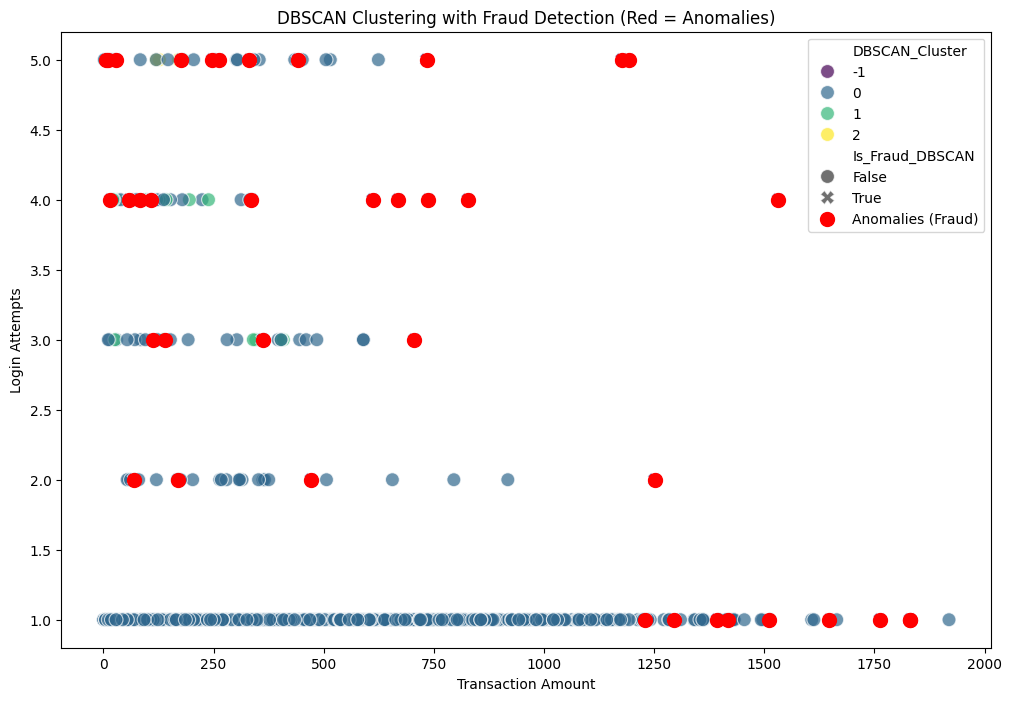

In [87]:
## viewing login attempts

# visualize
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=bank_data['TransactionAmount'],
    y=bank_data['LoginAttempts'],
    hue=bank_data['DBSCAN_Cluster'],
    palette='viridis',
    style=bank_data['Is_Fraud_DBSCAN'],
    markers={True: "X", False: "o"},
    s=100,
    alpha=0.7
)

# fraud points
fraud_points = bank_data[bank_data['Is_Fraud_DBSCAN']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['LoginAttempts'],
    color='red',
    label='Anomalies (Fraud)',
    s=100
)

plt.title("DBSCAN Clustering with Fraud Detection (Red = Anomalies)")
plt.xlabel("Transaction Amount")
plt.ylabel("Login Attempts")
plt.legend()
plt.show()

Notice how our DBSCAN seems to recognize a different pattern from KNN, placing less weight on the number of login attempts and flagging various transactions with anywhere between 1-5 login attempts. However, that is not to say that DBSCAN does not recognize the importance of this variable as it classifies a significantly larger portion of transactions that need all 5 login attempts as fraud vs 1st try.

# Gaussian mixture model


Taking our lessons from above, we can get straight to doing our GMM analysis with the PCA data

In [88]:
gmm_pca = GaussianMixture(n_components=4, random_state=42)
gmm_pca.fit(PCA_reduced_bank_data)

GaussianMixture(n_components=4, random_state=42)

Number of detected fraudulent transactions (GMM): 26
Anomalous transactions (top 5 - GMM):
    TransactionID AccountID  TransactionAmount     TransactionDate  \
274      TX000275   AC00454            1176.28 2023-12-20 16:08:02   
340      TX000341   AC00107            1830.00 2023-03-01 16:31:58   
341      TX000342   AC00171              26.06 2023-12-21 17:01:24   
375      TX000376   AC00316            1392.54 2023-11-20 16:51:14   
394      TX000395   AC00326               6.30 2023-12-14 18:52:54   

    TransactionType     Location DeviceID       IP Address MerchantID Channel  \
274          Credit  Kansas City  D000476      50.202.8.53       M074     ATM   
340           Debit  San Antonio  D000436    62.27.235.199       M082  Online   
341           Debit    San Diego  D000689  140.212.253.222       M096     ATM   
375           Debit      El Paso  D000113    63.67.150.226       M013  Branch   
394           Debit     Columbus  D000539    210.160.90.52       M017  Branch   

 

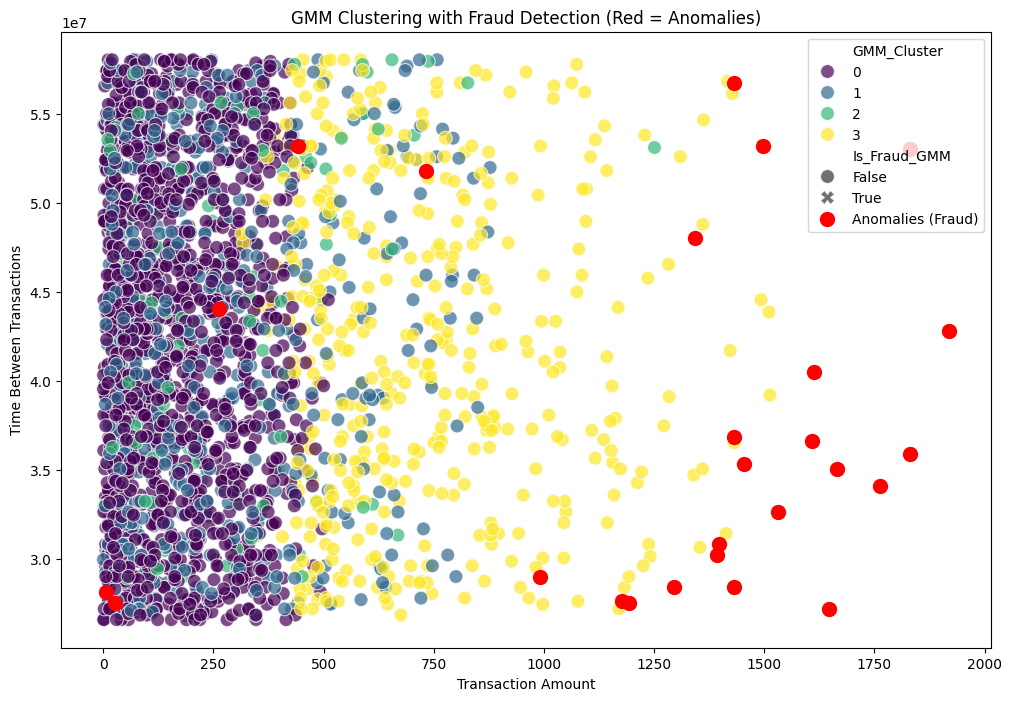

In [89]:

# Calculate distances to GMM cluster centers
cluster_centers = gmm_pca.means_
distances = cdist(PCA_reduced_bank_data, cluster_centers, metric='mahalanobis')
bank_data['Distance_to_GMM_Center'] = distances.min(axis=1)

# Add cluster labels to the dataset
bank_data['GMM_Cluster'] = gmm_pca.predict(PCA_reduced_bank_data)

# Define anomaly threshold using mean + 3 * std
threshold_gmm = bank_data['Distance_to_GMM_Center'].mean() + 3 * bank_data['Distance_to_GMM_Center'].std()
bank_data['Is_Fraud_GMM'] = bank_data['Distance_to_GMM_Center'] > threshold_gmm

# Results
print("Number of detected fraudulent transactions (GMM):", bank_data['Is_Fraud_GMM'].sum())
print("Anomalous transactions (top 5 - GMM):")
print(bank_data[bank_data['Is_Fraud_GMM']].head())

# Visualize
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=bank_data['TransactionAmount'],
    y=bank_data['time_between_transactions'],
    hue=bank_data['GMM_Cluster'],
    palette='viridis',
    style=bank_data['Is_Fraud_GMM'],
    markers={True: "X", False: "o"},
    s=100,
    alpha=0.7
)

fraud_points_gmm = bank_data[bank_data['Is_Fraud_GMM']]
plt.scatter(
    fraud_points_gmm['TransactionAmount'],
    fraud_points_gmm['time_between_transactions'],
    color='red',
    label='Anomalies (Fraud)',
    s=100
)

plt.title("GMM Clustering with Fraud Detection (Red = Anomalies)")
plt.xlabel("Transaction Amount")
plt.ylabel("Time Between Transactions")
plt.legend()
plt.show()

# Ensemble Learning Method

- Because we have identified that our data has high dimensionality, we wanted to compose a more robust anomaly detector for fraud by combining our k-means, DBSCAN, and Gaussian Mixture Model in an ensemble learning method so we can combine the predictions of multiple methods in attempt to improve our overall performance in identifying fraudulent activity and make our predictions more robust.

In [90]:
bank_data.head()

TransactionID AccountID  TransactionAmount     TransactionDate  \
0      TX000001   AC00128              14.09 2023-04-11 16:29:14   
1      TX000002   AC00455             376.24 2023-06-27 16:44:19   
2      TX000003   AC00019             126.29 2023-07-10 18:16:08   
3      TX000004   AC00070             184.50 2023-05-05 16:32:11   
4      TX000005   AC00411              13.45 2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  ...  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM  ...   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM  ...   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online  ...   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online  ...   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online  ...   

   time_between_transactions Cluster  Distance_to_Centroid  Is_Fraud  \
0                 49477134.0       0              1.183888     False   
1                 42823516.0       0              1.779367     False   
2                 41694656.0       2              0.889540     False   
3                 47403415.0       0              1.605216     False   
4                 33228915.0       1              1.958723     False   

   PCA_Cluster DBSCAN_Cluster  Is_Fraud_DBSCAN  Distance_to_GMM_Center  \
0            0              0            False                1.220972   
1            0              0            False                1.873822   
2            1              0            False                0.820053   
3            0              0            False                1.444114   
4            1              0            False                1.734001   

   GMM_Cluster  Is_Fraud_GMM  
0            0         False  
1            3         False  
2            1         False  
3            0         False  
4            0         False  

[5 rows x 26 columns]

In [91]:
bank_data_ensemble = bank_data.copy()

In [92]:
bank_data_ensemble

TransactionID AccountID  TransactionAmount     TransactionDate  \
0         TX000001   AC00128              14.09 2023-04-11 16:29:14   
1         TX000002   AC00455             376.24 2023-06-27 16:44:19   
2         TX000003   AC00019             126.29 2023-07-10 18:16:08   
3         TX000004   AC00070             184.50 2023-05-05 16:32:11   
4         TX000005   AC00411              13.45 2023-10-16 17:51:24   
...            ...       ...                ...                 ...   
2507      TX002508   AC00297             856.21 2023-04-26 17:09:36   
2508      TX002509   AC00322             251.54 2023-03-22 17:36:48   
2509      TX002510   AC00095              28.63 2023-08-21 17:08:50   
2510      TX002511   AC00118             185.97 2023-02-24 16:24:46   
2511      TX002512   AC00009             243.08 2023-02-14 16:21:23   

     TransactionType          Location DeviceID      IP Address MerchantID  \
0              Debit         San Diego  D000380  162.198.218.92       M015   
1              Debit           Houston  D000051     13.149.61.4       M052   
2              Debit              Mesa  D000235  215.97.143.157       M009   
3              Debit           Raleigh  D000187  200.13.225.150       M002   
4             Credit           Atlanta  D000308    65.164.3.100       M091   
...              ...               ...      ...             ...        ...   
2507          Credit  Colorado Springs  D000625    21.157.41.17       M072   
2508           Debit            Tucson  D000410  49.174.157.140       M029   
2509           Debit         San Diego  D000095     58.1.27.124       M087   
2510           Debit            Denver  D000634   21.190.11.223       M041   
2511          Credit      Jacksonville  D000215   59.127.135.25       M041   

     Channel  ...  time_between_transactions Cluster  Distance_to_Centroid  \
0        ATM  ...                 49477134.0       0              1.183888   
1        ATM  ...                 42823516.0       0              1.779367   
2     Online  ...                 41694656.0       2              0.889540   
3     Online  ...                 47403415.0       0              1.605216   
4     Online  ...                 33228915.0       1              1.958723   
...      ...  ...                        ...     ...                   ...   
2507  Branch  ...                 48178913.0       0              0.964601   
2508  Branch  ...                 51201294.0       1              0.757952   
2509  Branch  ...                 38069989.0       1              0.996024   
2510  Online  ...                 53452056.0       2              1.874709   
2511  Online  ...                 54315986.0       2              1.312071   

      Is_Fraud  PCA_Cluster DBSCAN_Cluster  Is_Fraud_DBSCAN  \
0        False            0              0            False   
1        False            0              0            False   
2        False            1              0            False   
3        False            0              0            False   
4        False            1              0            False   
...        ...          ...            ...              ...   
2507     False            3              0            False   
2508     False            1              0            False   
2509     False            0              0            False   
2510     False            1              0            False   
2511     False            1              0            False   

      Distance_to_GMM_Center  GMM_Cluster  Is_Fraud_GMM  
0                   1.220972            0         False  
1                   1.873822            3         False  
2                   0.820053            1         False  
3                   1.444114            0         False  
4                   1.734001            0         False  
...                      ...          ...           ...  
2507                0.868077            3         False  
2508                0.955642            0         False  

In [93]:
# Initializing and Running our models

# k-means
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
bank_data_ensemble['KMeans_Cluster'] = kmeans.fit_predict(PCA_reduced_bank_data)
bank_data_ensemble['KMeans_Distance'] = cdist(PCA_reduced_bank_data, kmeans.cluster_centers_, metric='euclidean').min(axis=1)

# dbscan
dbscan = DBSCAN(eps=.8, min_samples=5)  # Adjust eps and min_samples for your data
bank_data_ensemble['DBSCAN_Cluster'] = dbscan.fit_predict(PCA_reduced_bank_data)

# gmm
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(PCA_reduced_bank_data)
bank_data_ensemble['GMM_Cluster'] = gmm.predict(PCA_reduced_bank_data)
distances = cdist(PCA_reduced_bank_data, gmm.means_, metric='mahalanobis')
bank_data_ensemble['GMM_Distance'] = distances.min(axis=1)

In [94]:
# identifying anomolies in each model

# Kmeans anomoly from before
threshold_kmeans = distances.mean() + 3 * distances.std()
bank_data_ensemble['KMeans_IsFraud'] = bank_data_ensemble['KMeans_Distance'] > threshold_kmeans

# DBSCAN anomaly from before
bank_data_ensemble['DBSCAN_IsFraud'] = bank_data_ensemble['DBSCAN_Cluster'] == -1

# GMM anomalies from before
threshold_gmm = bank_data_ensemble['GMM_Distance'].mean() + 3 * bank_data_ensemble['GMM_Distance'].std()
bank_data_ensemble['GMM_IsFraud'] = bank_data_ensemble['GMM_Distance'] > threshold_gmm

In [95]:
# define fraudulent anomaly if 2 out of the 3 methods identify an observation as fraud
bank_data_ensemble['Ensemble_IsFraud'] = (bank_data_ensemble[['KMeans_IsFraud', 'DBSCAN_IsFraud', 'GMM_IsFraud']].sum(axis=1) >= 2)

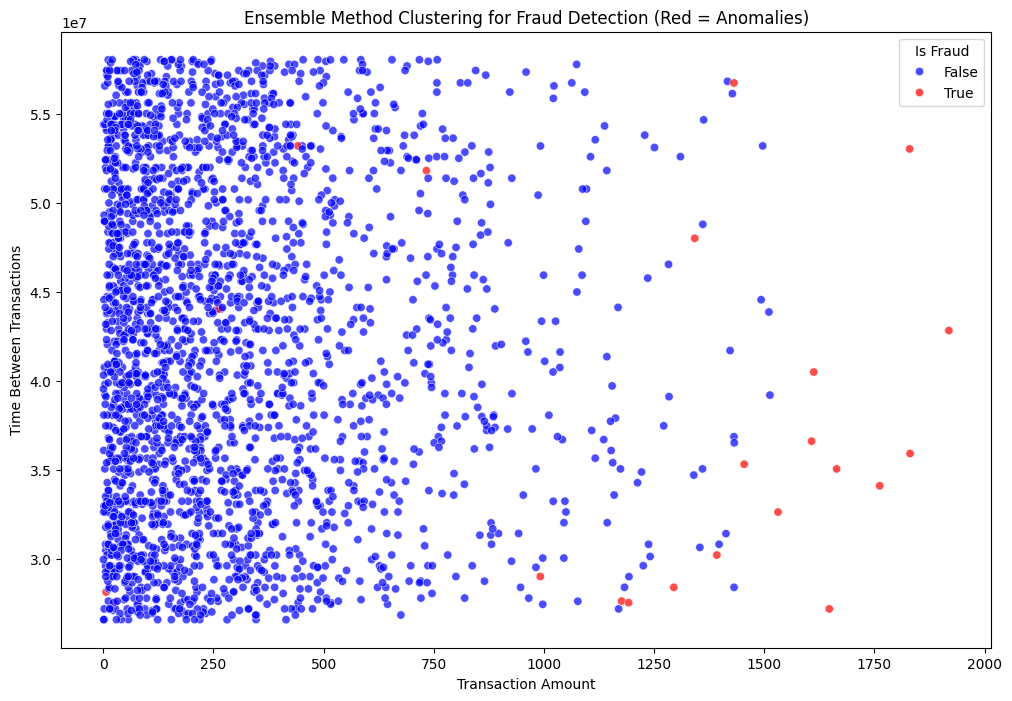

In [96]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x = bank_data_ensemble['TransactionAmount'],
    y = bank_data_ensemble['time_between_transactions'],
    hue = bank_data_ensemble['Ensemble_IsFraud'],
    palette = {False: 'blue', True: 'red'},
    alpha = .7
)

plt.title("Ensemble Method Clustering for Fraud Detection (Red = Anomalies)")
plt.xlabel("Transaction Amount")
plt.ylabel("Time Between Transactions")
plt.legend(title="Is Fraud", loc="upper right")
plt.show()

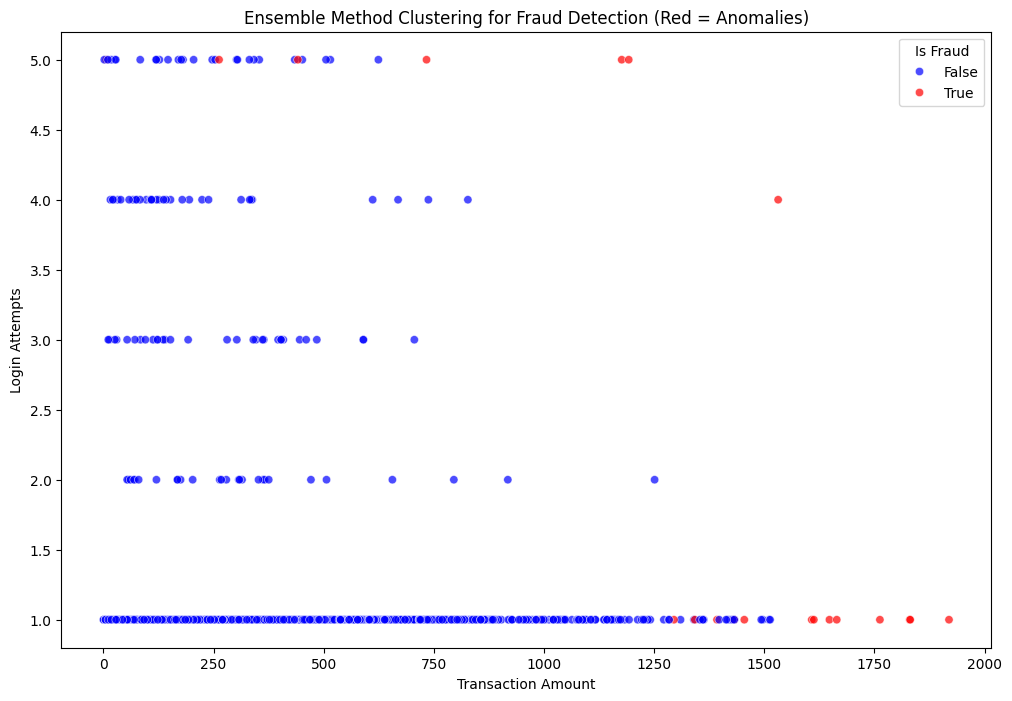

In [97]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x = bank_data_ensemble['TransactionAmount'],
    y = bank_data_ensemble['LoginAttempts'],
    hue = bank_data_ensemble['Ensemble_IsFraud'],
    palette = {False: 'blue', True: 'red'},
    alpha = .7
)

plt.title("Ensemble Method Clustering for Fraud Detection (Red = Anomalies)")
plt.xlabel("Transaction Amount")
plt.ylabel("Login Attempts")
plt.legend(title="Is Fraud", loc="upper right")
plt.show()

In [98]:
# run this if you don't have umap installed
!pip install umap-learn

In [99]:
import umap
import altair as alt

umap_vis = umap.UMAP(n_components=4, random_state=42)
umap_data = umap_vis.fit_transform(scaled_bank_data)

# UMAP projections to the original DataFrame
bank_data_ensemble['x_mono'] = umap_data[:, 0]
bank_data_ensemble['y_mono'] = umap_data[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [100]:
bank_data_ensemble.head()

TransactionID AccountID  TransactionAmount     TransactionDate  \
0      TX000001   AC00128              14.09 2023-04-11 16:29:14   
1      TX000002   AC00455             376.24 2023-06-27 16:44:19   
2      TX000003   AC00019             126.29 2023-07-10 18:16:08   
3      TX000004   AC00070             184.50 2023-05-05 16:32:11   
4      TX000005   AC00411              13.45 2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  ...  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM  ...   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM  ...   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online  ...   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online  ...   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online  ...   

   Is_Fraud_GMM KMeans_Cluster  KMeans_Distance  GMM_Distance  KMeans_IsFraud  \
0         False              0         1.183888      1.220972           False   
1         False              0         1.779367      1.873822           False   
2         False              1         0.889540      0.820053           False   
3         False              0         1.605216      1.444114           False   
4         False              1         1.958723      1.734001           False   

  DBSCAN_IsFraud  GMM_IsFraud  Ensemble_IsFraud    x_mono    y_mono  
0          False        False             False -0.831370  0.466297  
1          False        False             False  0.785843 -0.098406  
2          False        False             False  2.322356  7.759588  
3          False        False             False  1.872171  0.657310  
4          False        False             False  1.263667  0.682313  

[5 rows x 35 columns]

In [101]:
# time difference between transactions
bank_data_ensemble['time_between_transactions'] = (bank_data_ensemble['TransactionDate'] - bank_data_ensemble['PreviousTransactionDate']).dt.total_seconds()

#I am multiplying this by negative one because 'TransactionDate' is actually before 'PreviousTransactionDate' chronologically (prevent negative values)
bank_data_ensemble['time_between_transactions'] = bank_data_ensemble['time_between_transactions'] * -1

In [102]:
bank_data_ensemble.head()

TransactionID AccountID  TransactionAmount     TransactionDate  \
0      TX000001   AC00128              14.09 2023-04-11 16:29:14   
1      TX000002   AC00455             376.24 2023-06-27 16:44:19   
2      TX000003   AC00019             126.29 2023-07-10 18:16:08   
3      TX000004   AC00070             184.50 2023-05-05 16:32:11   
4      TX000005   AC00411              13.45 2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  ...  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM  ...   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM  ...   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online  ...   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online  ...   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online  ...   

   Is_Fraud_GMM KMeans_Cluster  KMeans_Distance  GMM_Distance  KMeans_IsFraud  \
0         False              0         1.183888      1.220972           False   
1         False              0         1.779367      1.873822           False   
2         False              1         0.889540      0.820053           False   
3         False              0         1.605216      1.444114           False   
4         False              1         1.958723      1.734001           False   

  DBSCAN_IsFraud  GMM_IsFraud  Ensemble_IsFraud    x_mono    y_mono  
0          False        False             False -0.831370  0.466297  
1          False        False             False  0.785843 -0.098406  
2          False        False             False  2.322356  7.759588  
3          False        False             False  1.872171  0.657310  
4          False        False             False  1.263667  0.682313  

[5 rows x 35 columns]

In [103]:
base = alt.Chart(bank_data_ensemble, title="UMAP Interactive Visualization for Fraudulent Activity Detected by Our Ensemble Learning Method").mark_circle(size=50, opacity=0.7).encode(
    alt.X('x_mono:Q', title='UMAP Dimension 1'),
    alt.Y('y_mono:Q', title='UMAP Dimension 2'),
    opacity=alt.Opacity('CustomerAge:Q', title='CustomerAge'),
    color=alt.Color('Ensemble_IsFraud:N', scale=alt.Scale(domain=[False, True], range=['blue', 'red']), title="Anomaly Status"),
    tooltip=[
        'TransactionAmount:Q',
        'TransactionDuration:Q',
        'AccountBalance:Q',
        'LoginAttempts:Q',
        'CustomerAge:Q',
        'time_between_transactions:Q',
        'Ensemble_IsFraud:N'
    ]
).interactive().properties(
    width=700,
    height=500
)

base

alt.Chart(...)

- After some exploration of the above UMAP representation of our ensemble, we were able to identify a significantly more isolated cluster of detected anomolies. When hovering over the data, we can actually see (without any computation necessary) that the bigger cluser of fraud occured with transactions that took *more* than one login attempt, which went against our k-means predictions, but seems to be well accounted for in our ensemble approach. Visibly, we also notice that this group of observations has customer ages that are generally over the age of 25-30, which makes sense as (unfortunately), many older folks fall victim to bank fraud.
- We can visualize customer age where more opaque is older and less opaque is younger. Within the cluster of identified fraud activity, we see that the age is relatively high.

In [104]:
ensemble_data_no_fraud = bank_data_ensemble[bank_data_ensemble['Ensemble_IsFraud'] == False]
ensemble_data_fraud = bank_data_ensemble[bank_data_ensemble['Ensemble_IsFraud'] == True]

In [105]:
# summary statistics for observations our ensemble labels as NO FRAUD

ensemble_data_no_fraud[['TransactionAmount','CustomerAge','LoginAttempts','AccountBalance','time_between_transactions']].describe()

TransactionAmount  CustomerAge  LoginAttempts  AccountBalance  \
count        2490.000000  2490.000000    2490.000000     2490.000000   
mean          289.319185    44.673896       1.114859     5103.184827   
std           274.380582    17.792374       0.571575     3890.705624   
min             0.260000    18.000000       1.000000      101.250000   
25%            81.180000    27.000000       1.000000     1504.727500   
50%           207.930000    45.000000       1.000000     4734.110000   
75%           407.650000    59.000000       1.000000     7645.017500   
max          1512.990000    80.000000       5.000000    14977.990000   

       time_between_transactions  
count               2.490000e+03  
mean                4.215933e+07  
std                 9.177807e+06  
min                 2.657429e+07  
25%                 3.411824e+07  
50%                 4.195875e+07  
75%                 5.016923e+07  
max                 5.803267e+07

In [106]:
# summary statistics for observations our ensemble labels as FRAUD

ensemble_data_fraud[['TransactionAmount','CustomerAge','LoginAttempts','AccountBalance','time_between_transactions']].describe()

TransactionAmount  CustomerAge  LoginAttempts  AccountBalance  \
count          22.000000    22.000000      22.000000       22.000000   
mean         1234.127273    44.681818       2.227273     6372.674091   
std           584.273103    18.190490       1.849886     4870.537907   
min             6.300000    18.000000       1.000000      323.690000   
25%          1037.935000    30.000000       1.000000     1509.957500   
50%          1411.935000    44.000000       1.000000     5897.985000   
75%          1638.897500    59.500000       4.750000    10924.430000   
max          1919.110000    80.000000       5.000000    13704.920000   

       time_between_transactions  
count               2.200000e+01  
mean                3.751224e+07  
std                 9.759370e+06  
min                 2.718168e+07  
25%                 2.854604e+07  
50%                 3.517710e+07  
75%                 4.372777e+07  
max                 5.672991e+07

- looking at the summary statistics of those observations of our ensemble learning methods identification of observations as Fraud or No Fraud, we can see a few distinct differences.

1. Average "Transaction Amount" for identified fraudulent activity is higher at 490.30 dollars compared to the average of normal activity at 293.60 dollars
2. Average number of "Login Attempts" for indentified fraudulent activity is higher at ~4.16 login attempts, which is much higher than the average number of Login Attempts for normal activity at ~1.06 attempts
3. While we believe older folks may be more susceptible to targeted fraud, it seems as though the average customer age for observations labels as Fraud or No Fraud is about the same at around 44 years old, with those identified as fraud with a very slightly older average age. We believe this may be due to larger distribution on normal activity. If we look at the standard deviation between the two, we can see that fraudulant cases see a standard deviation of ~19.1 years while normal cases have a lower standard deviation at ~17.7 years.

## **Most Suspicious Transactions**

In [107]:
# normalize distances for each method
bank_data_ensemble['KMeans_Score'] = bank_data_ensemble['KMeans_Distance'] / bank_data_ensemble['KMeans_Distance'].max()
bank_data_ensemble['GMM_Score'] = bank_data_ensemble['GMM_Distance'] / bank_data_ensemble['GMM_Distance'].max()

# DBSCAN uses binary anomaly flag (0 or 1) as the score
bank_data_ensemble['DBSCAN_Score'] = bank_data_ensemble['DBSCAN_IsFraud'].astype(float)

# assign weights to each method based on importance (I made DBSCAN lower due to how it is scored)
kmeans_weight = 0.4
gmm_weight = 0.4
dbscan_weight = 0.2

# compute fraud likelihood scores
bank_data_ensemble['Fraud_Likelihood'] = (
    kmeans_weight * bank_data_ensemble['KMeans_Score'] +
    gmm_weight * bank_data_ensemble['GMM_Score'] +
    dbscan_weight * bank_data_ensemble['DBSCAN_Score']
)


In [108]:
# calculate fraud likelihood

top_n = 10
top_suspicious_transactions = bank_data_ensemble.nlargest(top_n, 'Fraud_Likelihood')

columns_to_display = ['TransactionID', 'AccountID', 'TransactionAmount', 'LoginAttempts', 'CustomerAge', 'AccountBalance',
                       'time_between_transactions', 'Fraud_Likelihood']
top_fraud_table = top_suspicious_transactions[columns_to_display]

top_fraud_table


TransactionID AccountID  TransactionAmount  LoginAttempts  CustomerAge  \
898       TX000899   AC00083            1531.31              4           18   
1438      TX001439   AC00179            1831.02              1           62   
1634      TX001635   AC00358            1762.28              1           24   
1213      TX001214   AC00170            1192.20              5           60   
274       TX000275   AC00454            1176.28              5           54   
653       TX000654   AC00423            1919.11              1           30   
2414      TX002415   AC00028            1664.33              1           18   
394       TX000395   AC00326               6.30              5           80   
375       TX000376   AC00316            1392.54              1           41   
340       TX000341   AC00107            1830.00              1           55   

      AccountBalance  time_between_transactions  Fraud_Likelihood  
898           859.86                 32623571.0          1.000000  
1438        11498.01                 35908750.0          0.867389  
1634         1380.34                 34099508.0          0.847278  
1213         7816.41                 27532067.0          0.843447  
274           323.69                 27619422.0          0.843020  
653         11090.24                 42819722.0          0.837374  
2414         1588.31                 35045748.0          0.813292  
394          7697.68                 28127959.0          0.799725  
375         13347.69                 30208681.0          0.795456  
340          2235.70                 53019601.0          0.789415

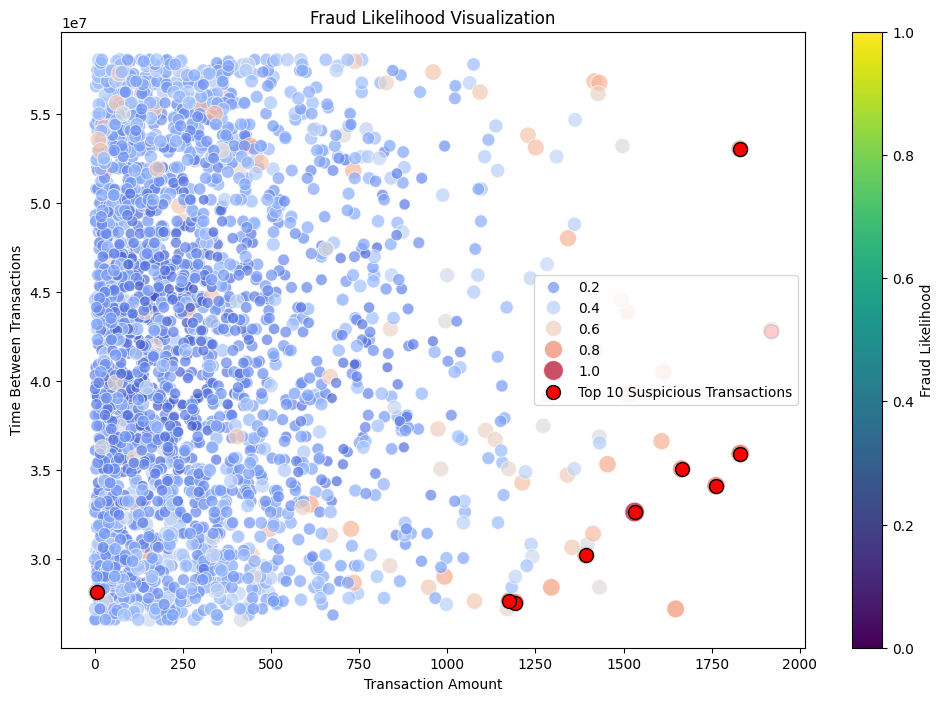

In [109]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=bank_data_ensemble['TransactionAmount'],
    y=bank_data_ensemble['time_between_transactions'],
    hue=bank_data_ensemble['Fraud_Likelihood'],
    palette='coolwarm',
    size=bank_data_ensemble['Fraud_Likelihood'],
    sizes=(50, 200),
    alpha=0.7
)

# top N Suspicious Transactions
plt.scatter(
    top_suspicious_transactions['TransactionAmount'],
    top_suspicious_transactions['time_between_transactions'],
    color='red',
    label=f'Top {top_n} Suspicious Transactions',
    s=100,
    edgecolor='black'
)

plt.title("Fraud Likelihood Visualization")
plt.xlabel("Transaction Amount")
plt.ylabel("Time Between Transactions")
plt.colorbar(label="Fraud Likelihood")
plt.legend()
plt.show()


### **Vulnerable AccountIDs**

In [110]:
# filter transactions with fraud likelihood greater than 50%
fraud_likelihood_threshold = 0.5
high_fraud_transactions = bank_data_ensemble[bank_data_ensemble['Fraud_Likelihood'] > fraud_likelihood_threshold]

# frequency of each Account ID
account_id_frequencies = high_fraud_transactions['AccountID'].value_counts()

# top Account IDs with their frequencies
top_account_id_frequencies = account_id_frequencies.head(10)
print(top_account_id_frequencies)


AccountID
AC00071    2
AC00316    2
AC00179    2
AC00098    2
AC00385    2
AC00018    2
AC00460    2
AC00039    2
AC00465    2
AC00358    2
Name: count, dtype: int64


**Logic:**

- The final fraud likelihood score is computed as a weighted sum of the normalized scores from K-Means, GMM, and DBSCAN. This score represents the likelihood of a transaction being fraudulent, considering the strengths of all three methods.

- The distances from cluster centroids (K-Means and GMM) are normalized by dividing them by their respective maximum values to ensure that their scales are comparable. For DBSCAN, the binary anomaly flag (0 for non-fraud, 1 for fraud) is directly used as its score.

**Score Calculations:**

K-Means: The distance of each point to its assigned cluster centroid is calculated.

Gaussian Mixture Model: The Mahalanobis distance of each data point to its assigned cluster center is calculated.

DBSCAN: The anomaly flag (Is_Fraud), indicating whether a point is noise (1 for fraud, 0 for non-fraud), is directly used as the DBSCAN_Score